<a href="https://colab.research.google.com/github/dasjyotishka/Predicting-Airbnb-Prices-in-New-York-City/blob/SHUBHAM/Predicting_price_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**README**

#Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.0 MB/s eta 0:00:00


#Importing libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from yellowbrick.target import BalancedBinningReference
from yellowbrick.regressor import PredictionError, ResidualsPlot
import os
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plt.rcParams["figure.figsize"] = (20,13)
# plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.facecolor']='#AFD0CB'

#Read dataset

In [4]:
data = pd.read_csv("/content/drive/MyDrive/ensemble/AB_NYC_2019.csv")
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

#Data Cleaning

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
# Checking how many null values there are in each column
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

###Removing null values

In [8]:
name_null_values = data.name.isnull()
host_null_values = data.host_name.isnull()
print('Percentage of data with an empty name:', len(data.loc[name_null_values])/len(data.id)*100)
print('Percentage of data with an empty host name:', len(data.loc[host_null_values])/len(data.id)*100)

Percentage of data with an empty name: 0.03272318232948154
Percentage of data with an empty host name: 0.04294917680744453


Since these are insignificant percentages of data, hence these rows can be ignored/removed.

In [9]:
data = data.loc[~name_null_values]
data = data.loc[~host_null_values]
data.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10037
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [10]:
data[data['last_review'].isnull()][['number_of_reviews','reviews_per_month']].head()

number_of_reviews  reviews_per_month
2                   0                NaN
19                  0                NaN
26                  0                NaN
36                  0                NaN
38                  0                NaN

If a certain listing has a null for its "last_review," that means it has not gotten a review at all(also proved from previous dataframe), so "reviews_per_month" must be 0. 
Also, now we can drop the last-review column containing null values from a cleaner dataset.


In [11]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.drop('last_review', inplace=True, axis=1)
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#Data Visualisations

[Text(0, 0, '25393'), Text(0, 0, '22306'), Text(0, 0, '1159')]

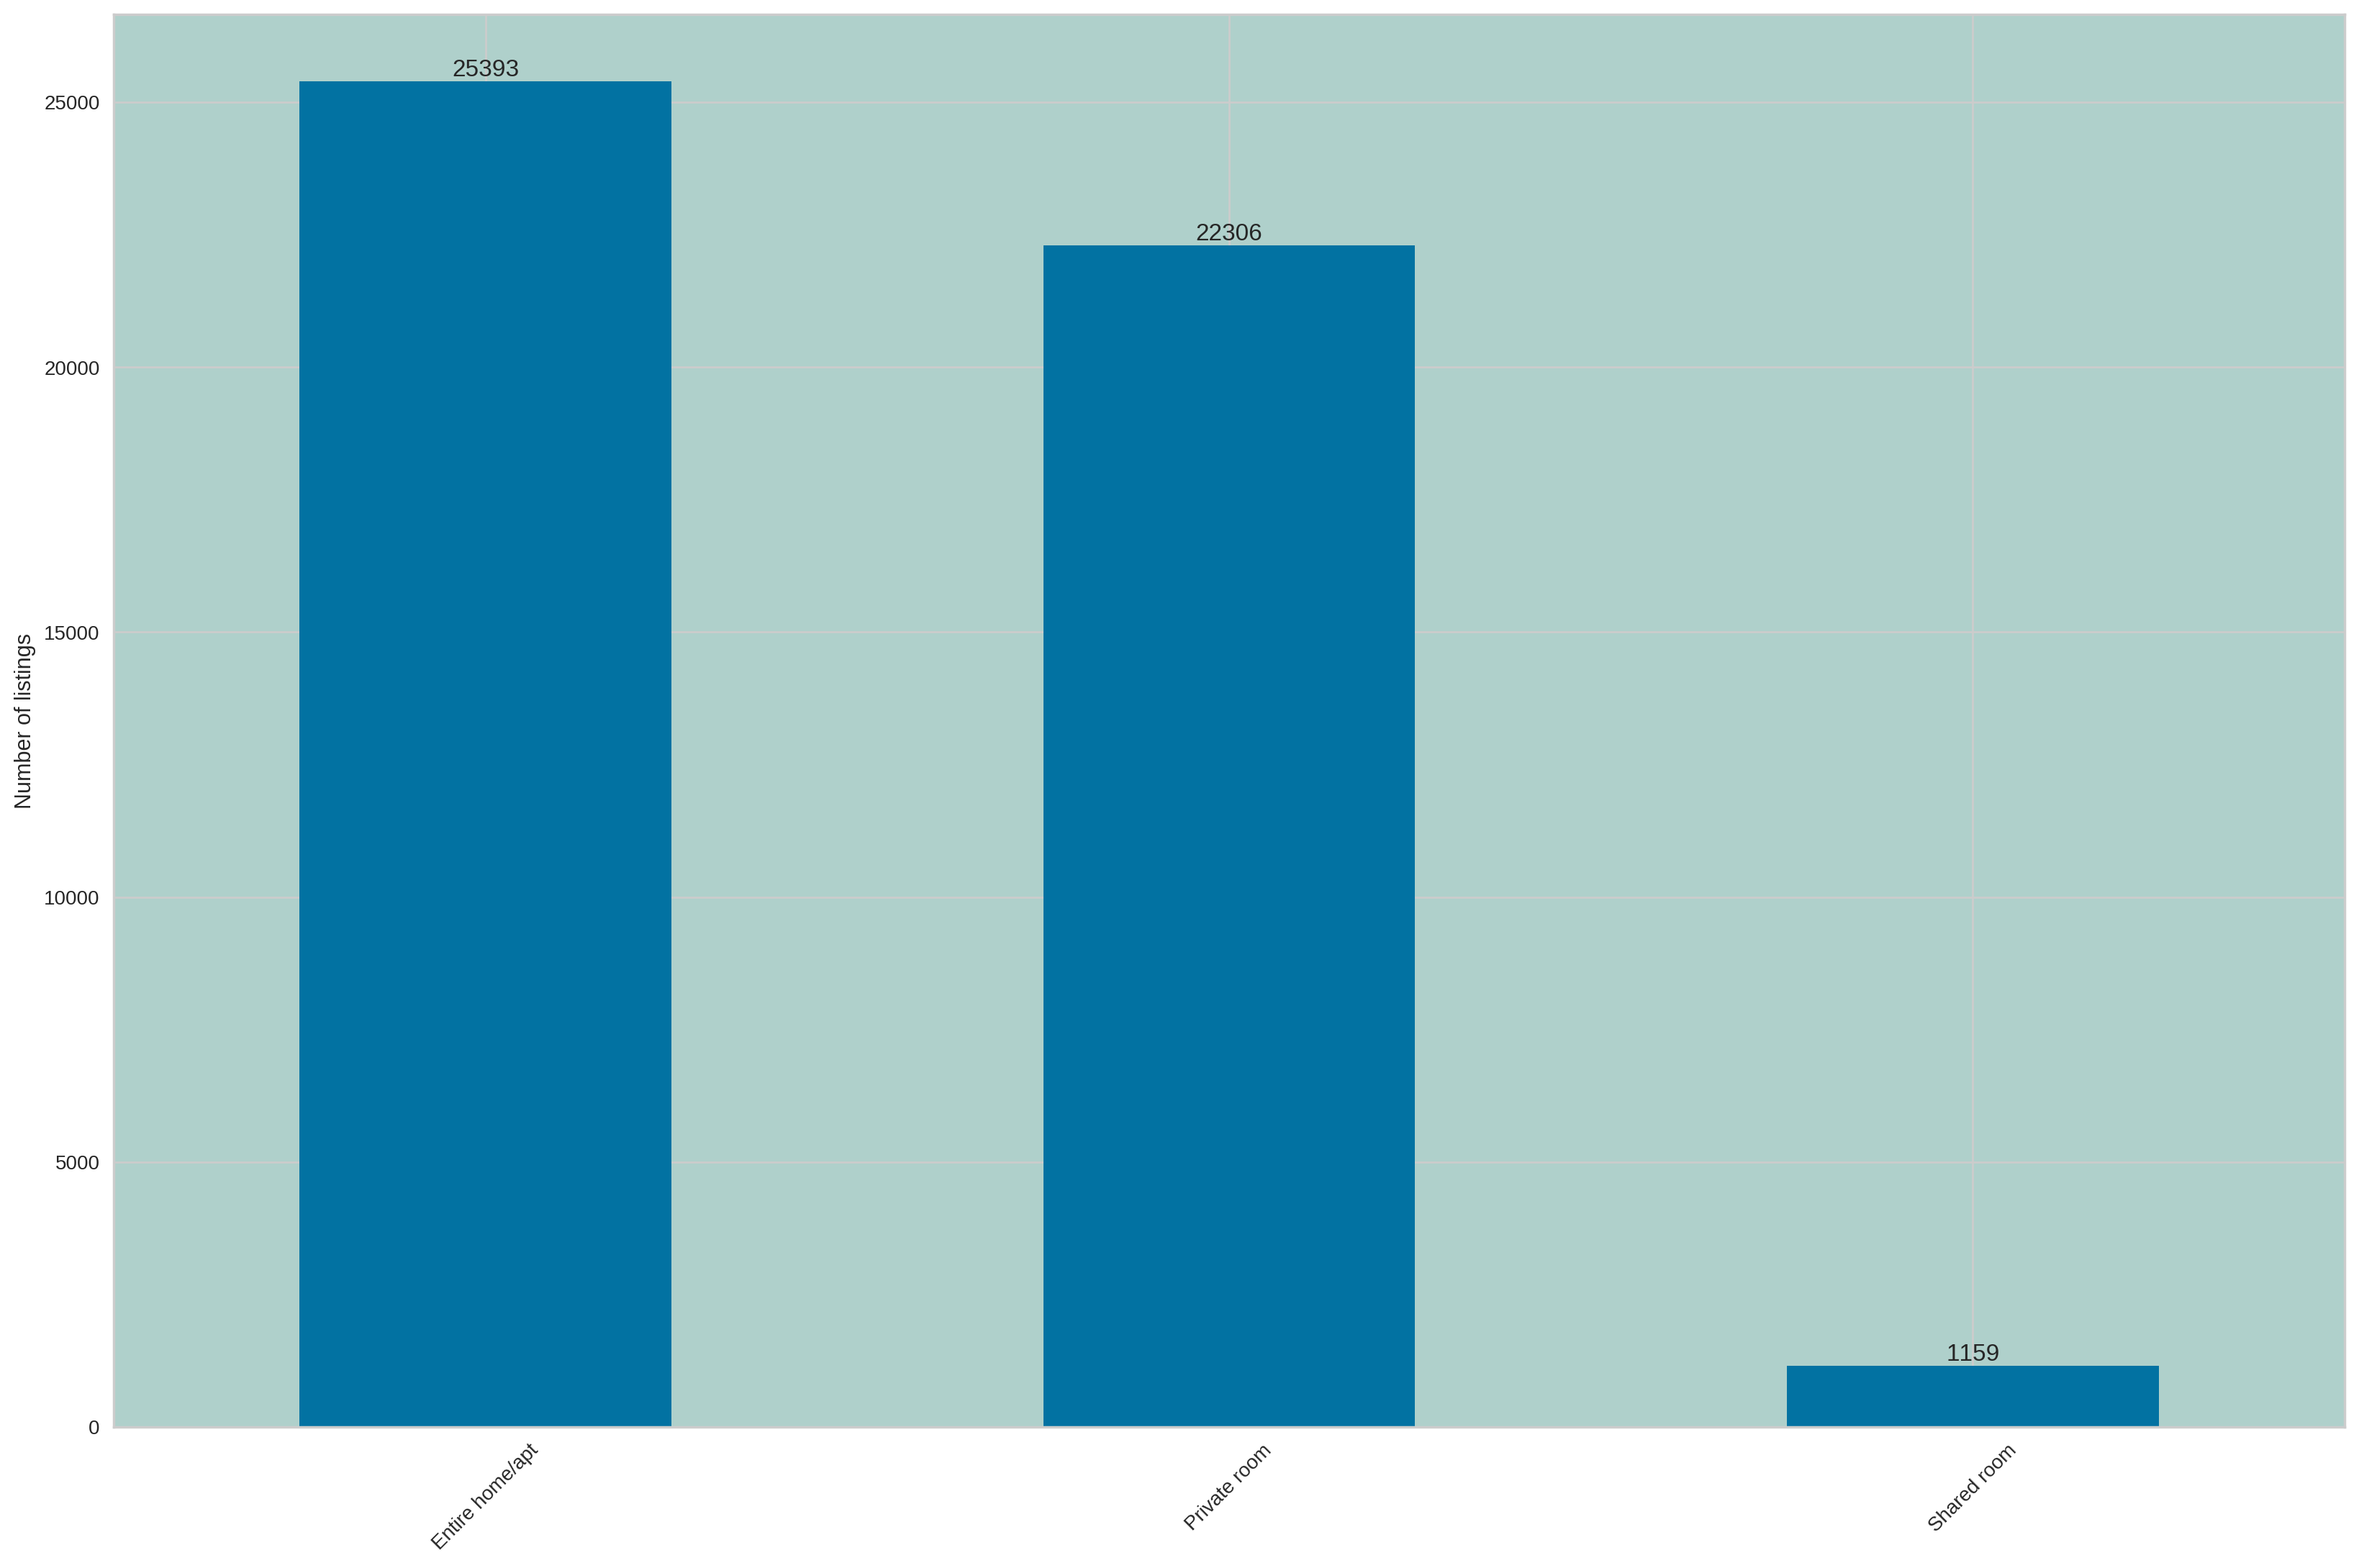

In [71]:
#room-type counts graph
ax4 = data.room_type.value_counts().plot.bar(rot=45)
ax4.set_ylabel("Number of listings")
ax4.bar_label(ax4.containers[0])

We see maximum listings are either Private room or Entire home/apt

In [13]:
#Avg. price and listings per neighbourhood_group(large area)
neighbourhood_group_df = data.groupby('neighbourhood_group').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
neighbourhood_group_df

neighbourhood_group   avg_price  count
0               Bronx   87.469238   1089
1            Brooklyn  124.410523  20089
2           Manhattan  196.897473  21643
3              Queens   99.536017   5664
4       Staten Island  114.812332    373

Text(0, 0.5, '')

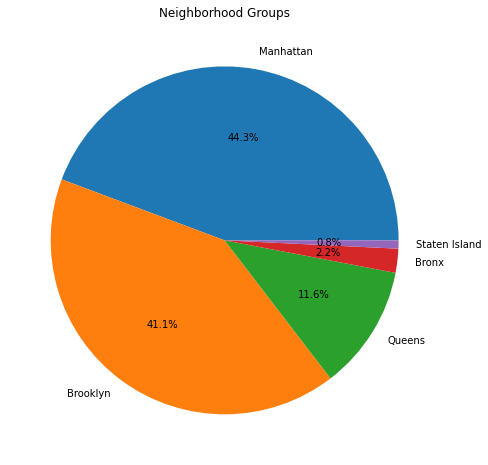

In [ ]:
#Pie chart to show listings in each neighbourhood group
ax1 = data.neighbourhood_group.value_counts().plot.pie(title='Neighborhood Groups',
                                               figsize=(8,8),
                                              autopct='%1.1f%%')
ax1.set_ylabel(None)

We see that more than 85% of listings are located in Manhattan and Brooklyn.

<Axes: xlabel='neighbourhood_group'>

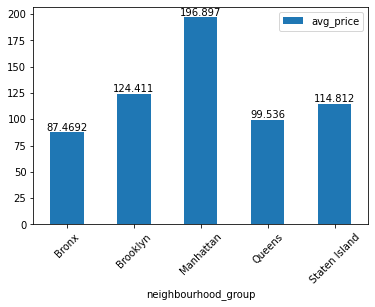

In [ ]:
ax4 = neighbourhood_group_df.plot.bar(rot=45, x='neighbourhood_group', y='avg_price')
ax4.bar_label(ax4.containers[0])
ax4

We see that highest average price is of listings are located in Manhattan

In [21]:
print("There are", data["neighbourhood"].nunique(), "distinct values.")

There are 221 distinct values.


Text(0.5, 1.0, 'Top 10 Neighbourhood')

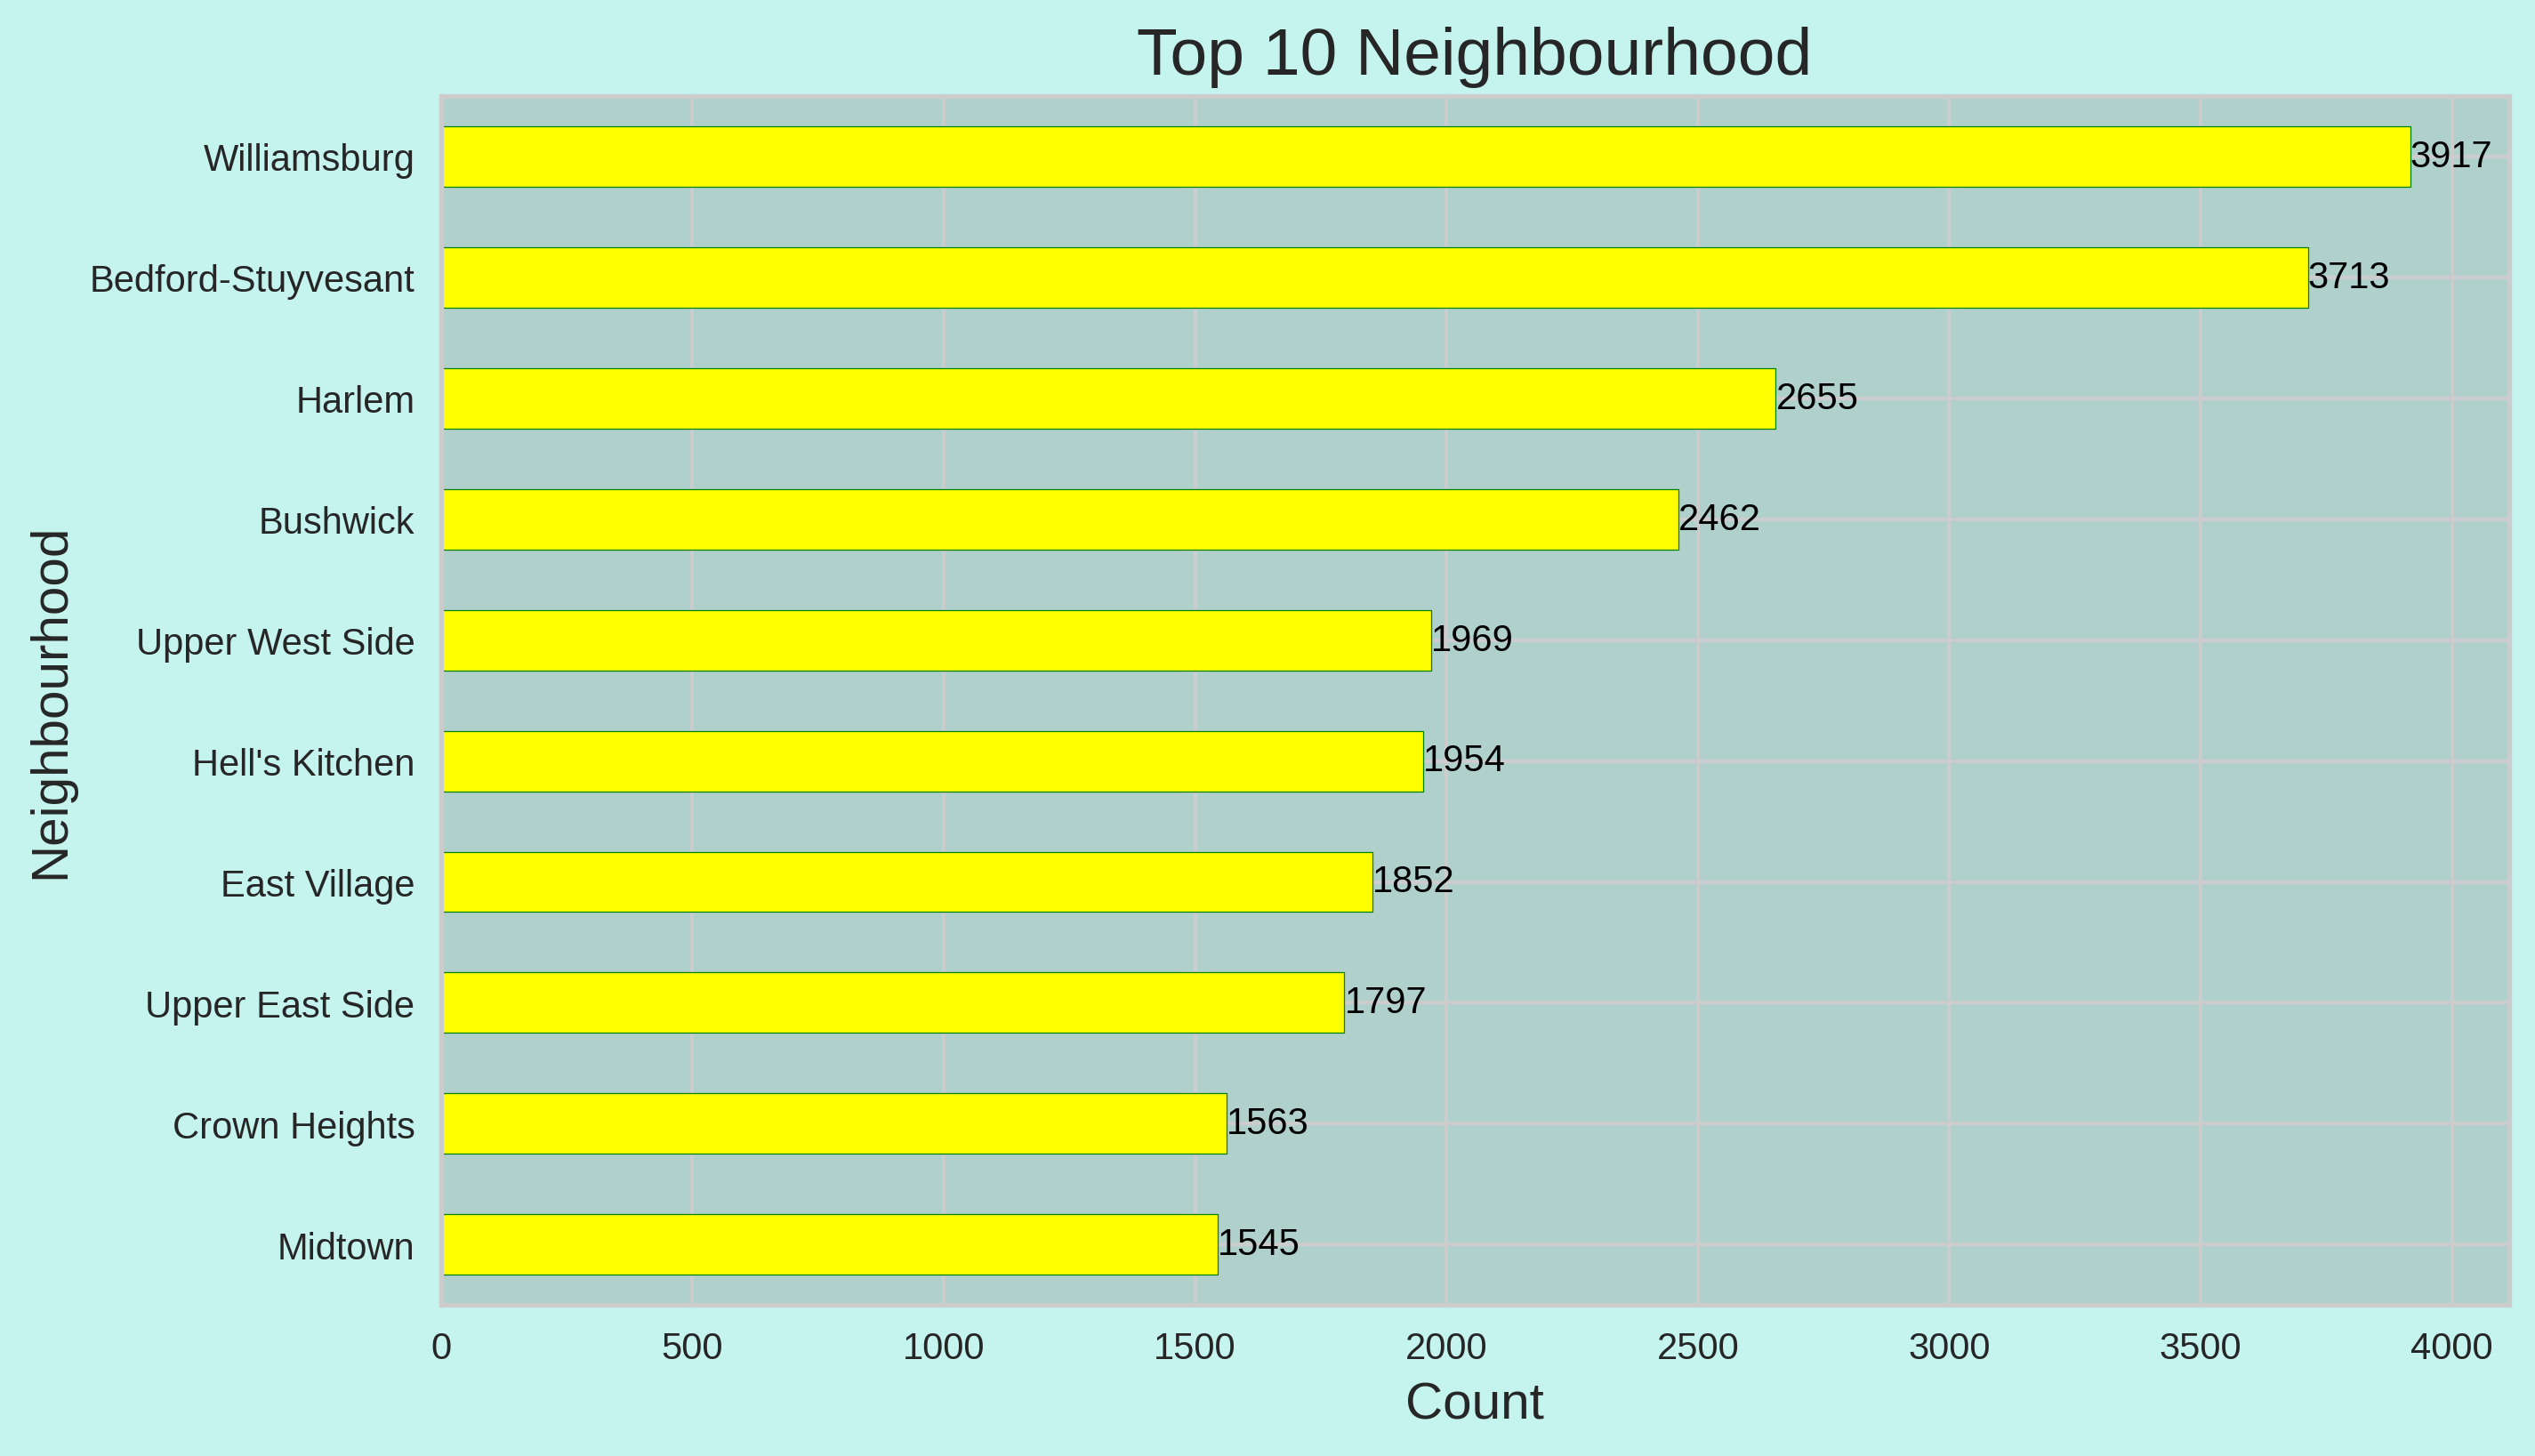

In [23]:
plt.figure(facecolor='#C5F3ED')
ax = plt.axes()
data["neighbourhood"].value_counts().head(10).sort_values().plot(kind = "barh", 
                                                               color = "yellow",
                                                               edgecolor="green")
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=10)
plt.xlabel("Count", size = 14)
plt.ylabel("Neighbourhood", size = 14)
plt.title("Top 10 Neighbourhood", size = 18)

Text(0.5, 1.0, 'Top 20 Neighbourhood with Highest Avg. Prices')

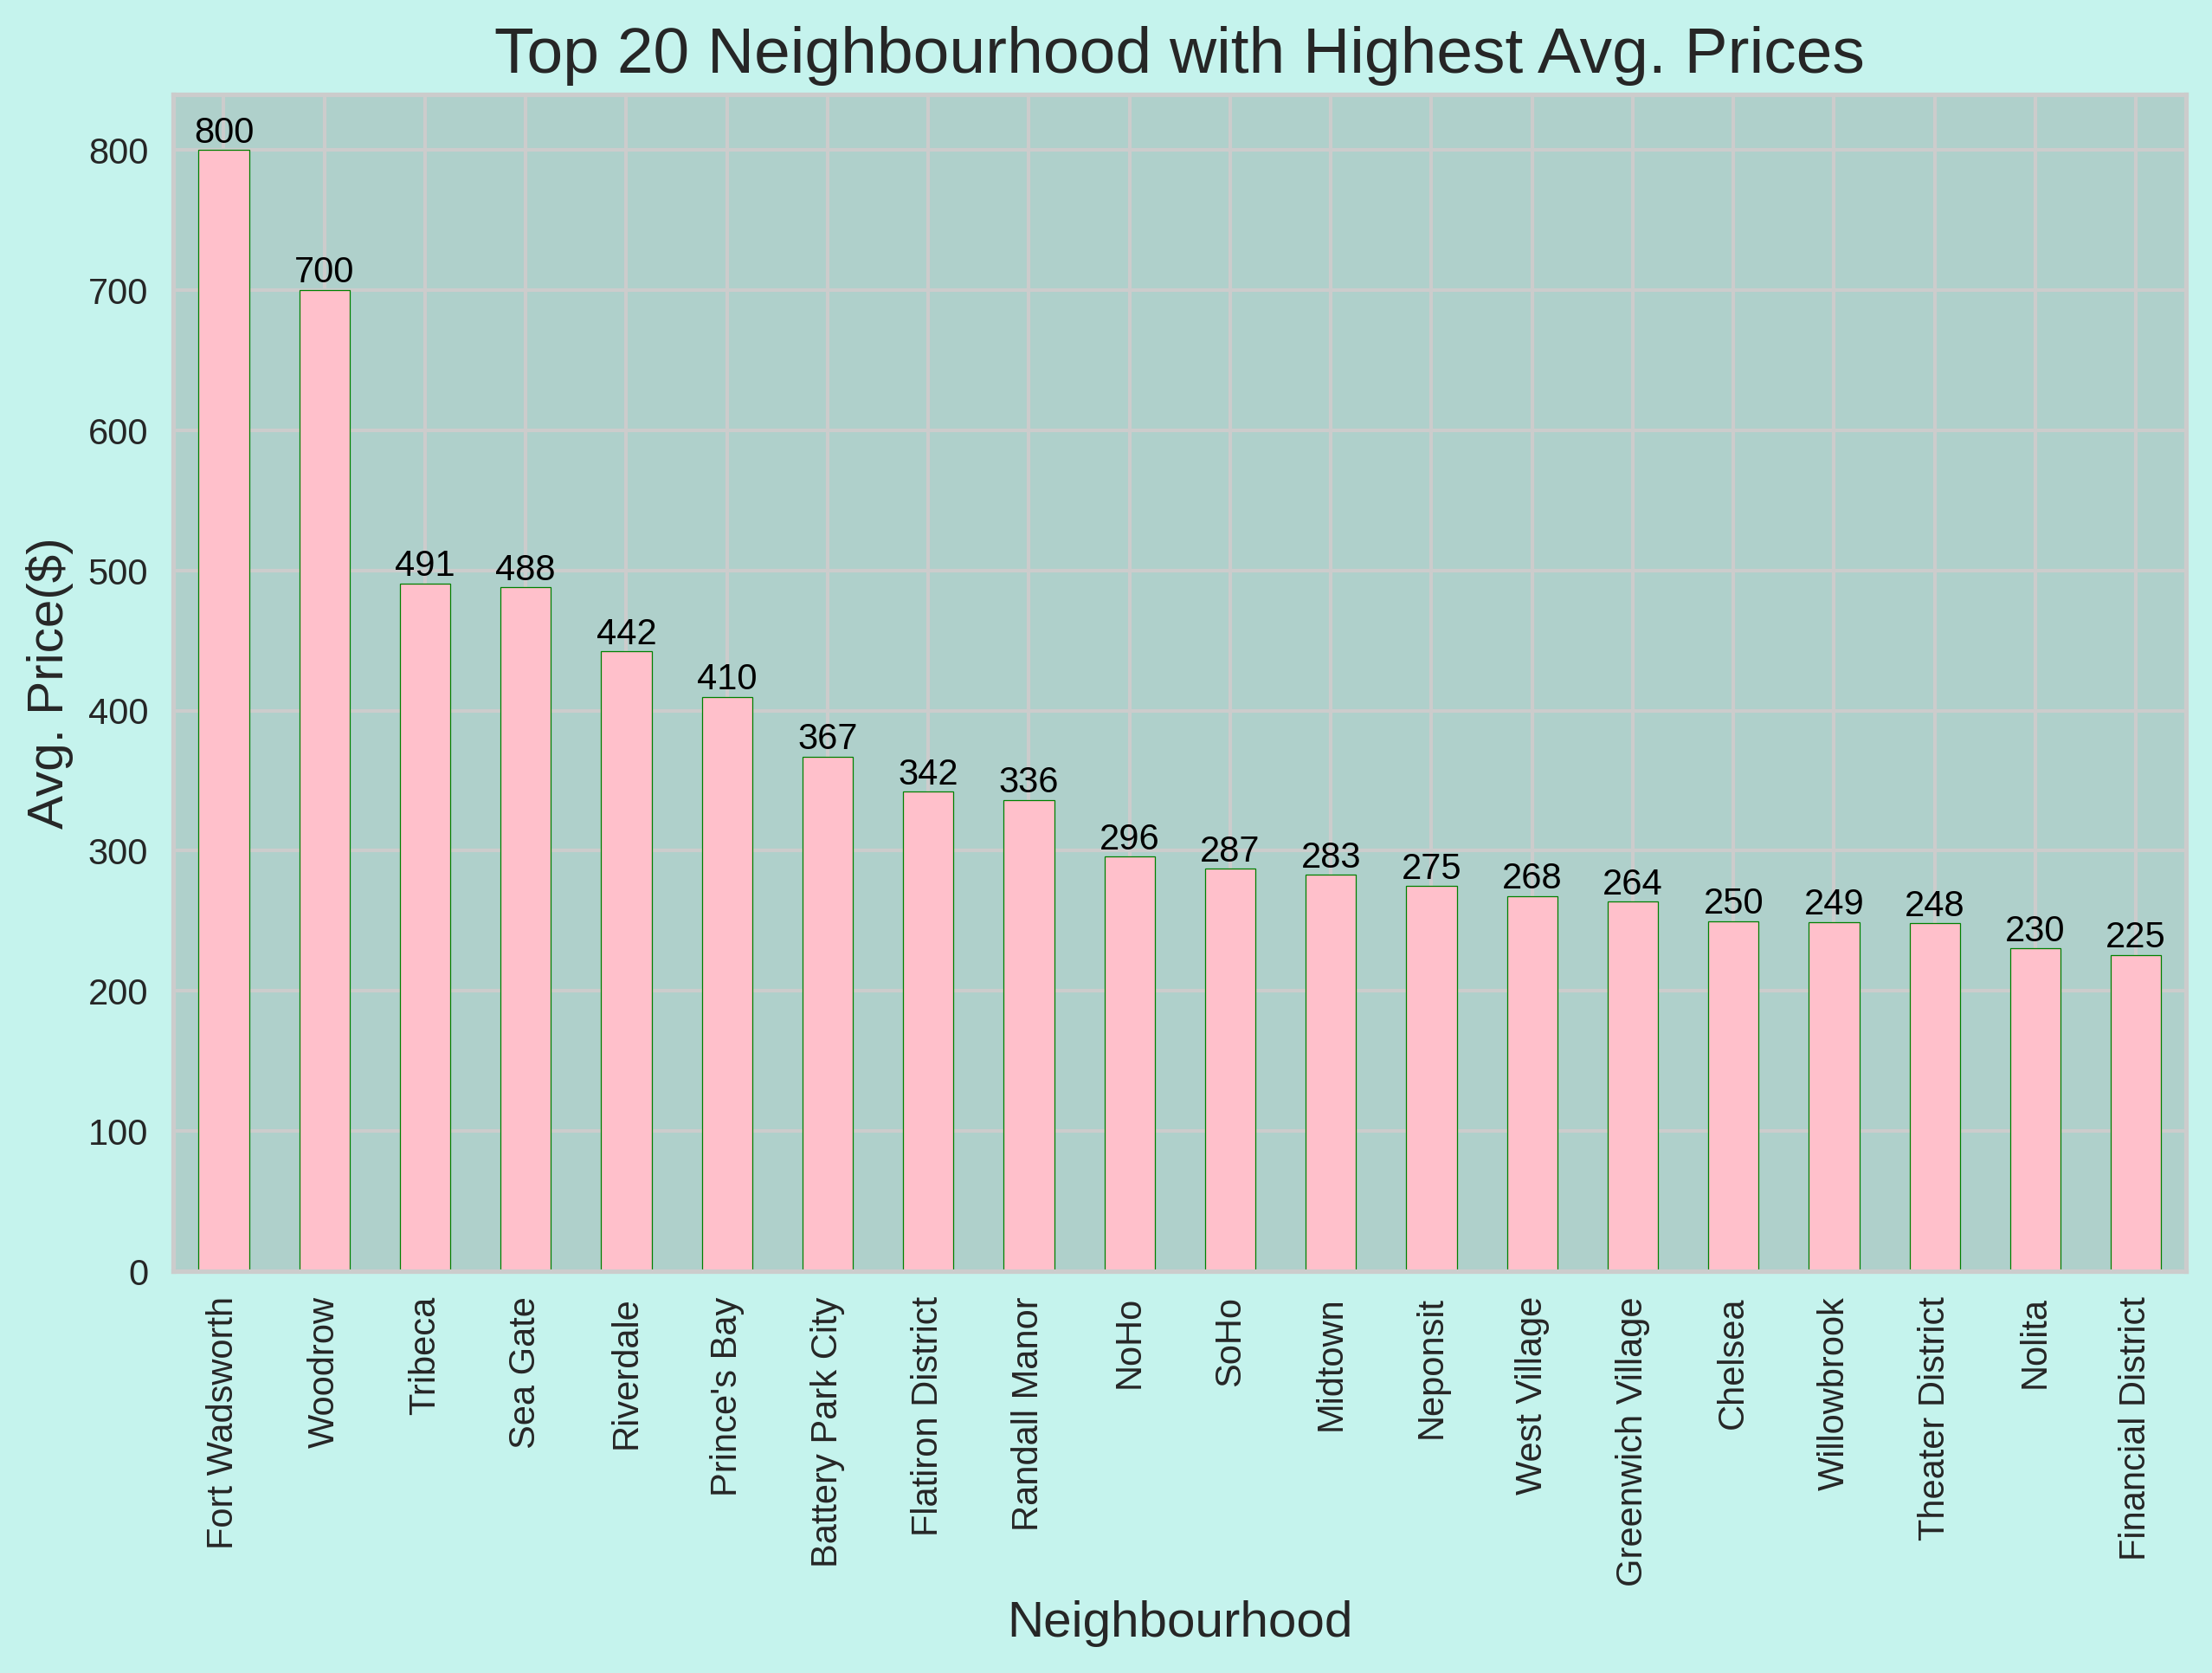

In [25]:
plt.figure(facecolor='#C5F3ED')
ax = plt.axes()
top_20_n_p_mean_df = data.groupby("neighbourhood")["price"].agg("mean").sort_values(ascending=False).head(20)
top_20_n_p_mean_df.sort_values(ascending=False).plot(kind = "bar", 
                                                     color = "pink", 
                                                     edgecolor="green")
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=10)
plt.xlabel("Neighbourhood", size = 14)
plt.ylabel("Avg. Price($)", size = 14)
plt.title("Top 20 Neighbourhood with Highest Avg. Prices", size = 18)

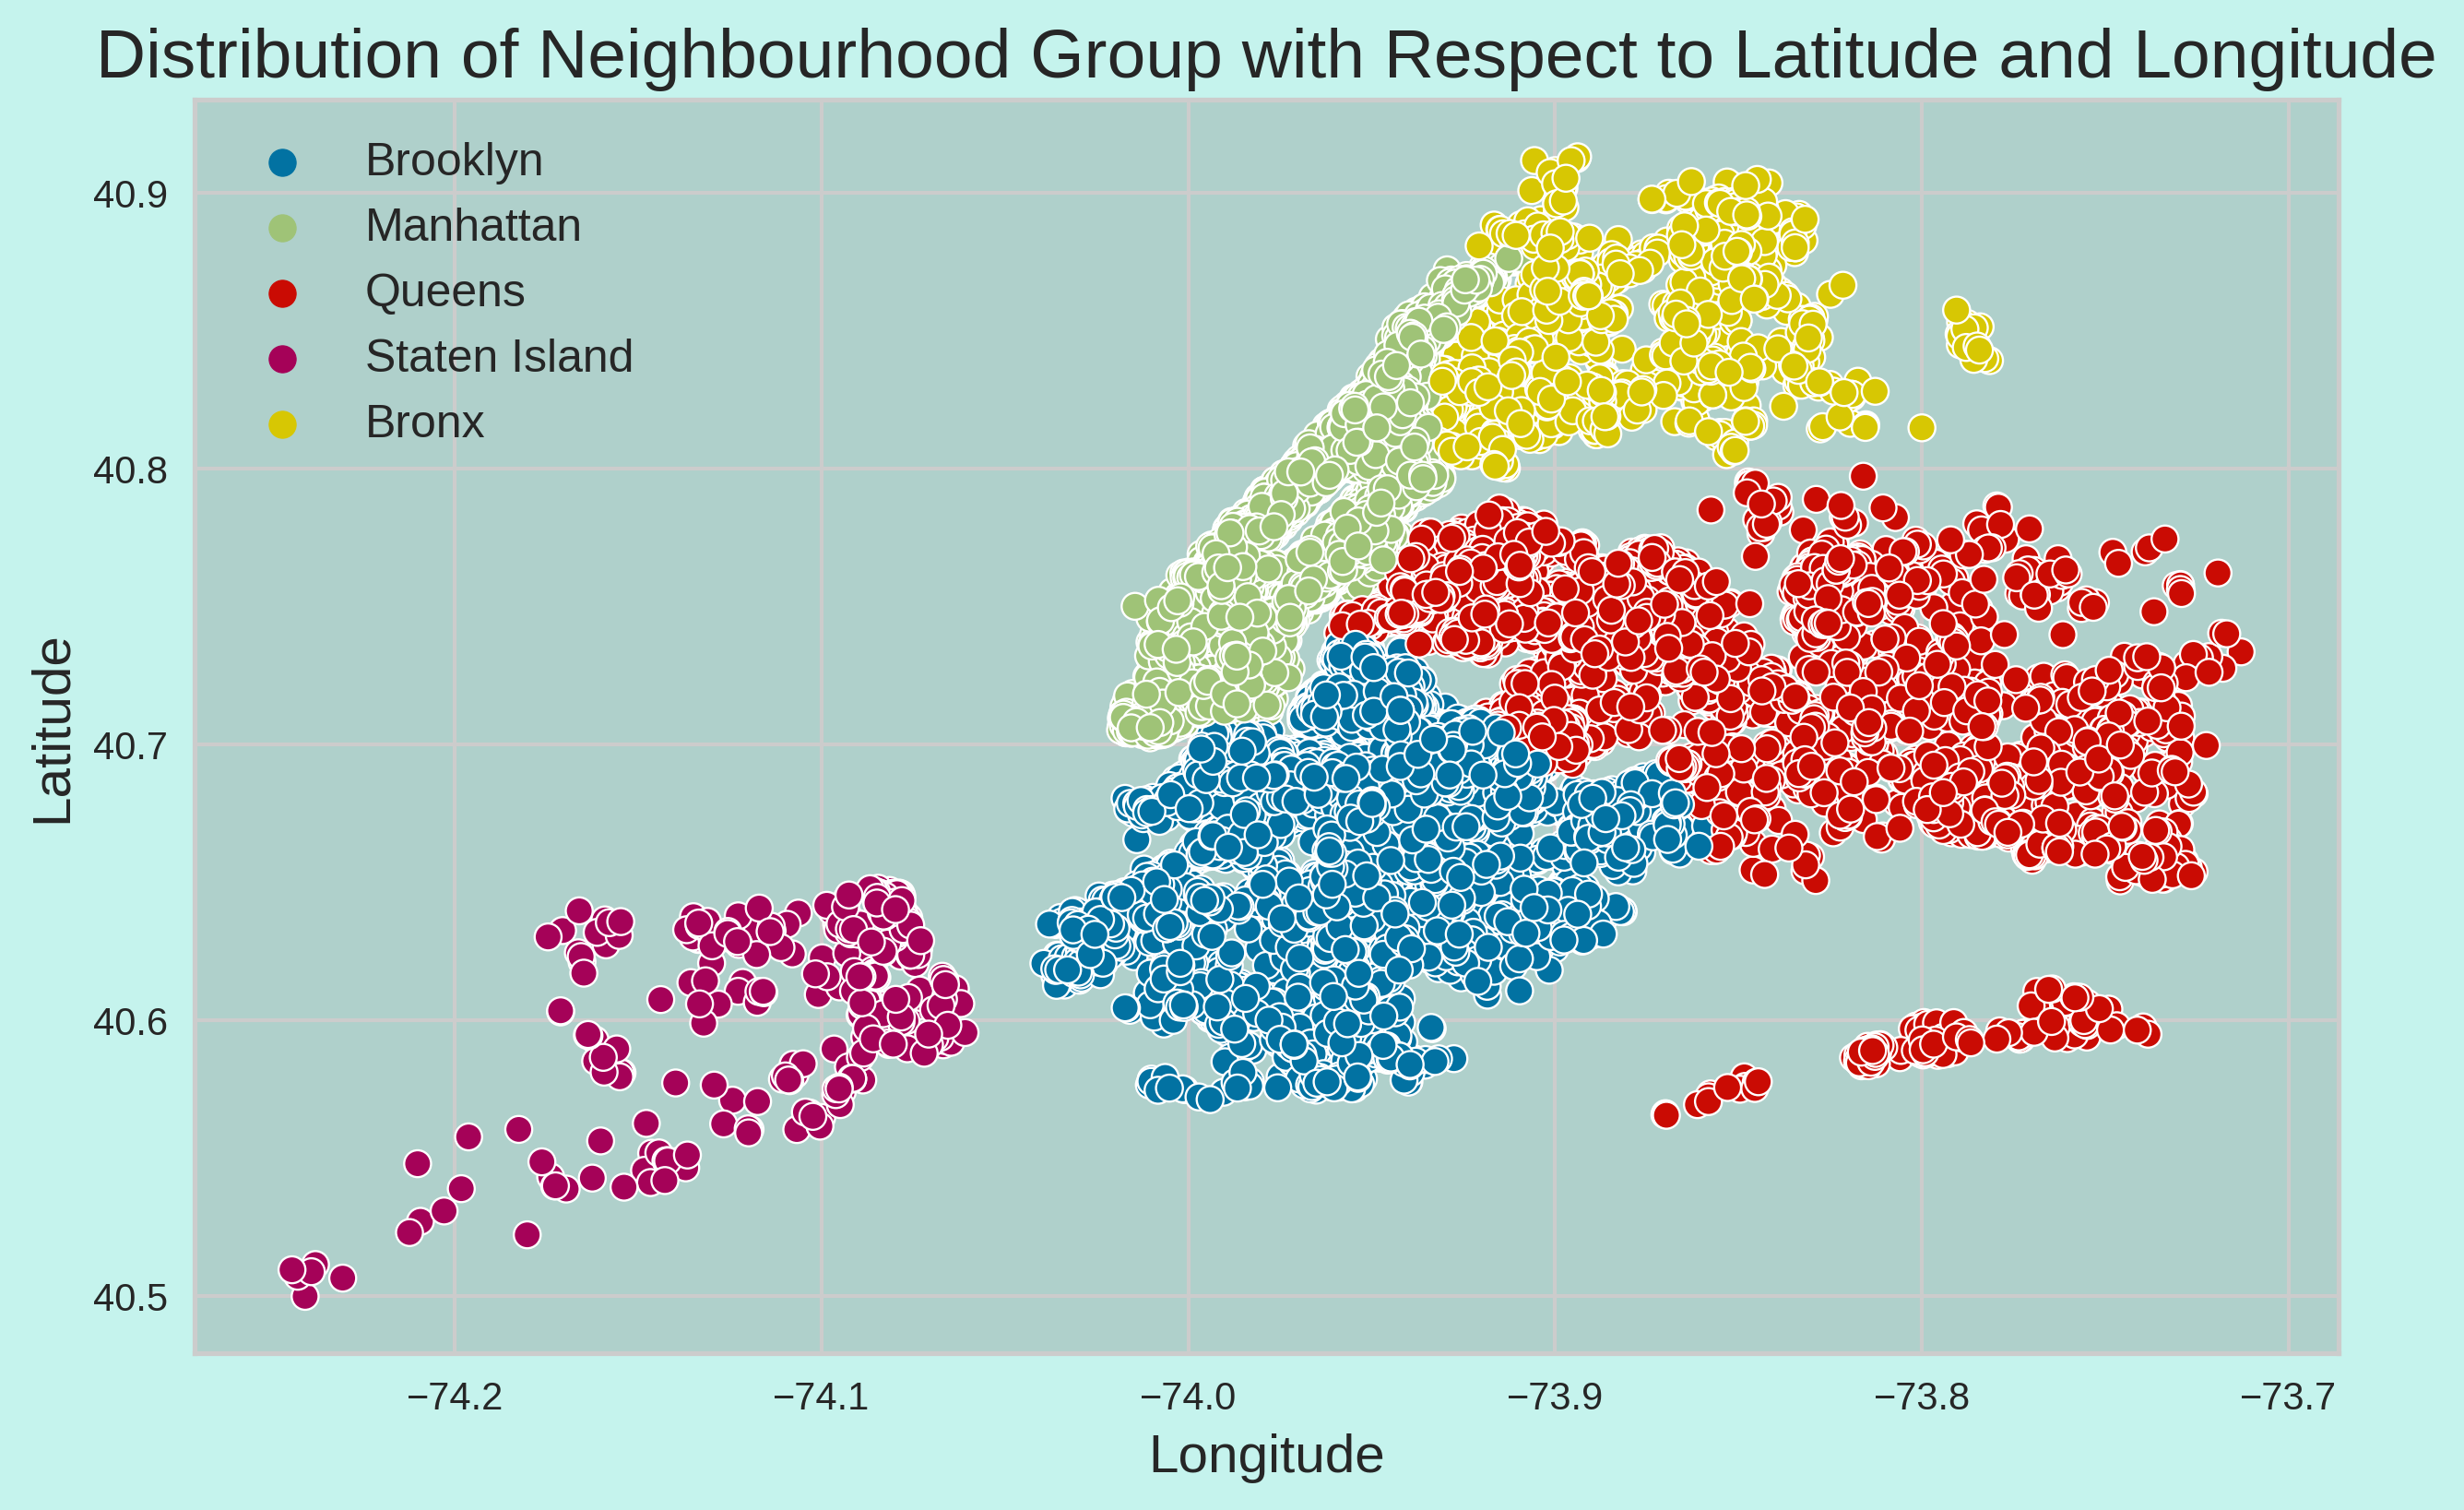

In [27]:
plt.figure(facecolor='#C5F3ED')
sns.scatterplot(data=data, x="longitude", y="latitude", hue="neighbourhood_group")
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Distribution of Neighbourhood Group with Respect to Latitude and Longitude", fontsize=18)
plt.legend(prop={"size":12})

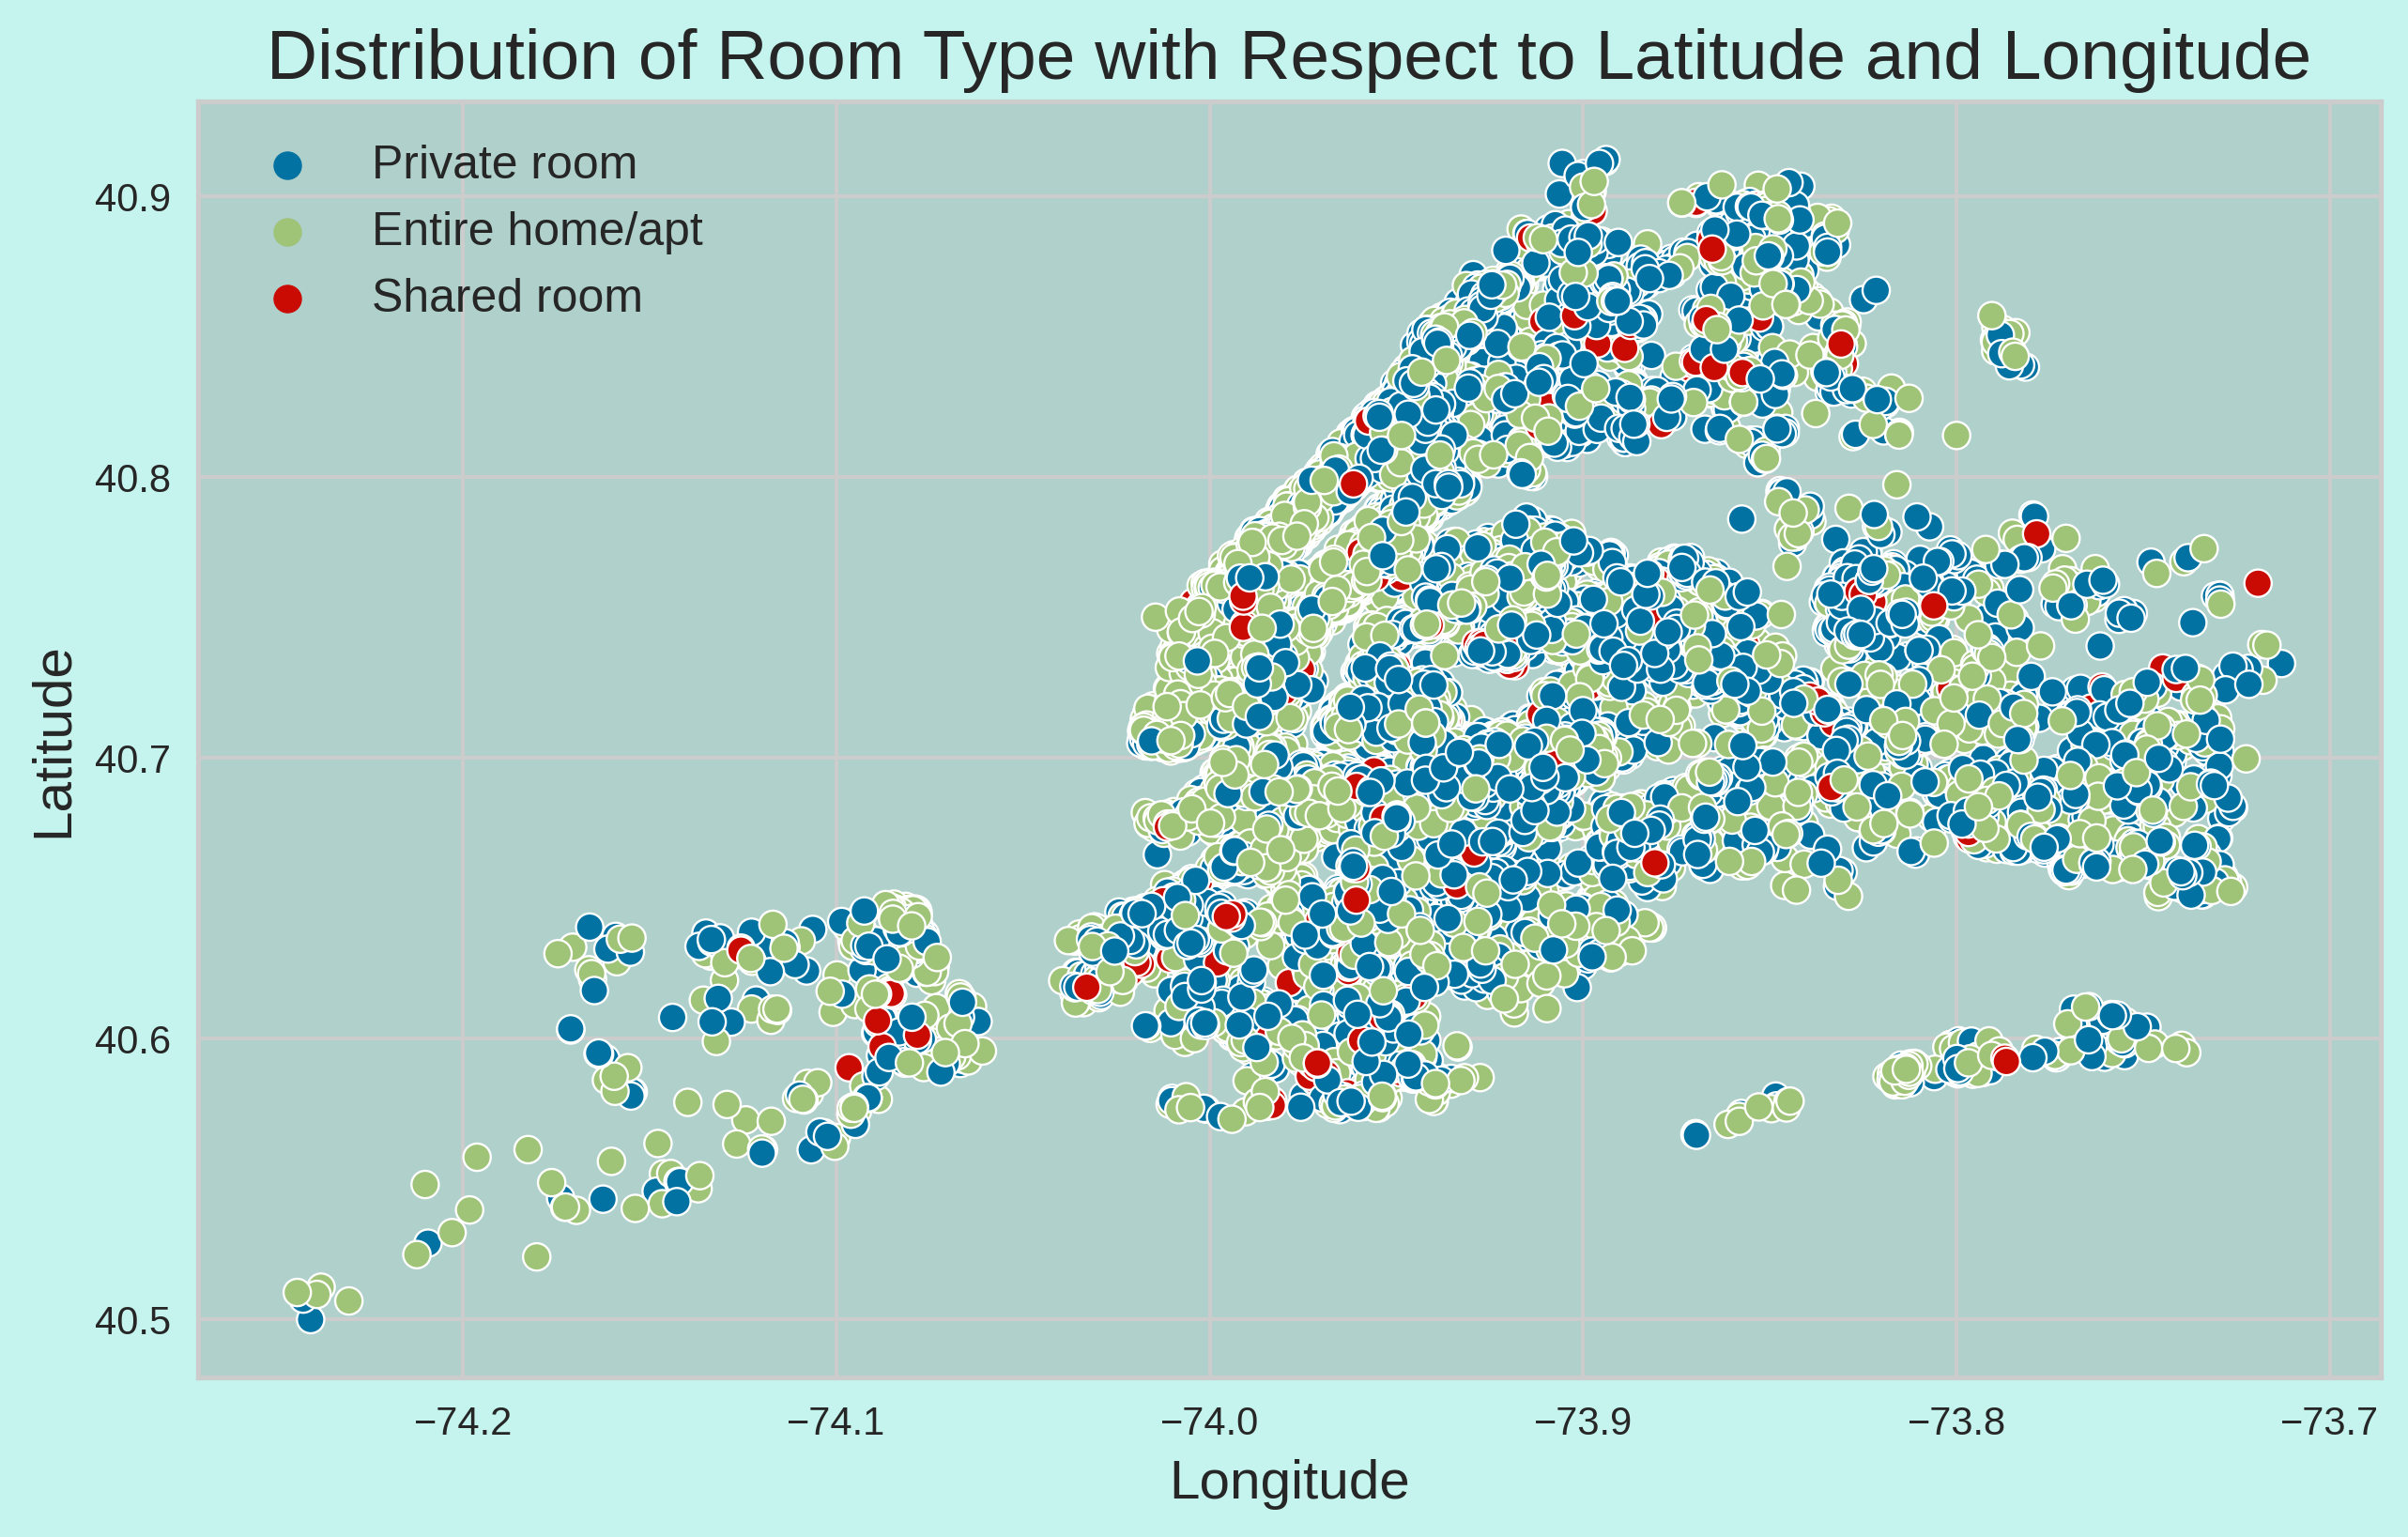

In [29]:
plt.figure(facecolor='#C5F3ED')
sns.scatterplot(data = data, x="longitude", y="latitude", hue="room_type")
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Distribution of Room Type with Respect to Latitude and Longitude", fontsize=18)
plt.legend(prop={"size":12})

Price will be our target column in this project. So, let's check the distribution of price.

Text(0.5, 1.0, 'Price Distribution After Log Transformation')

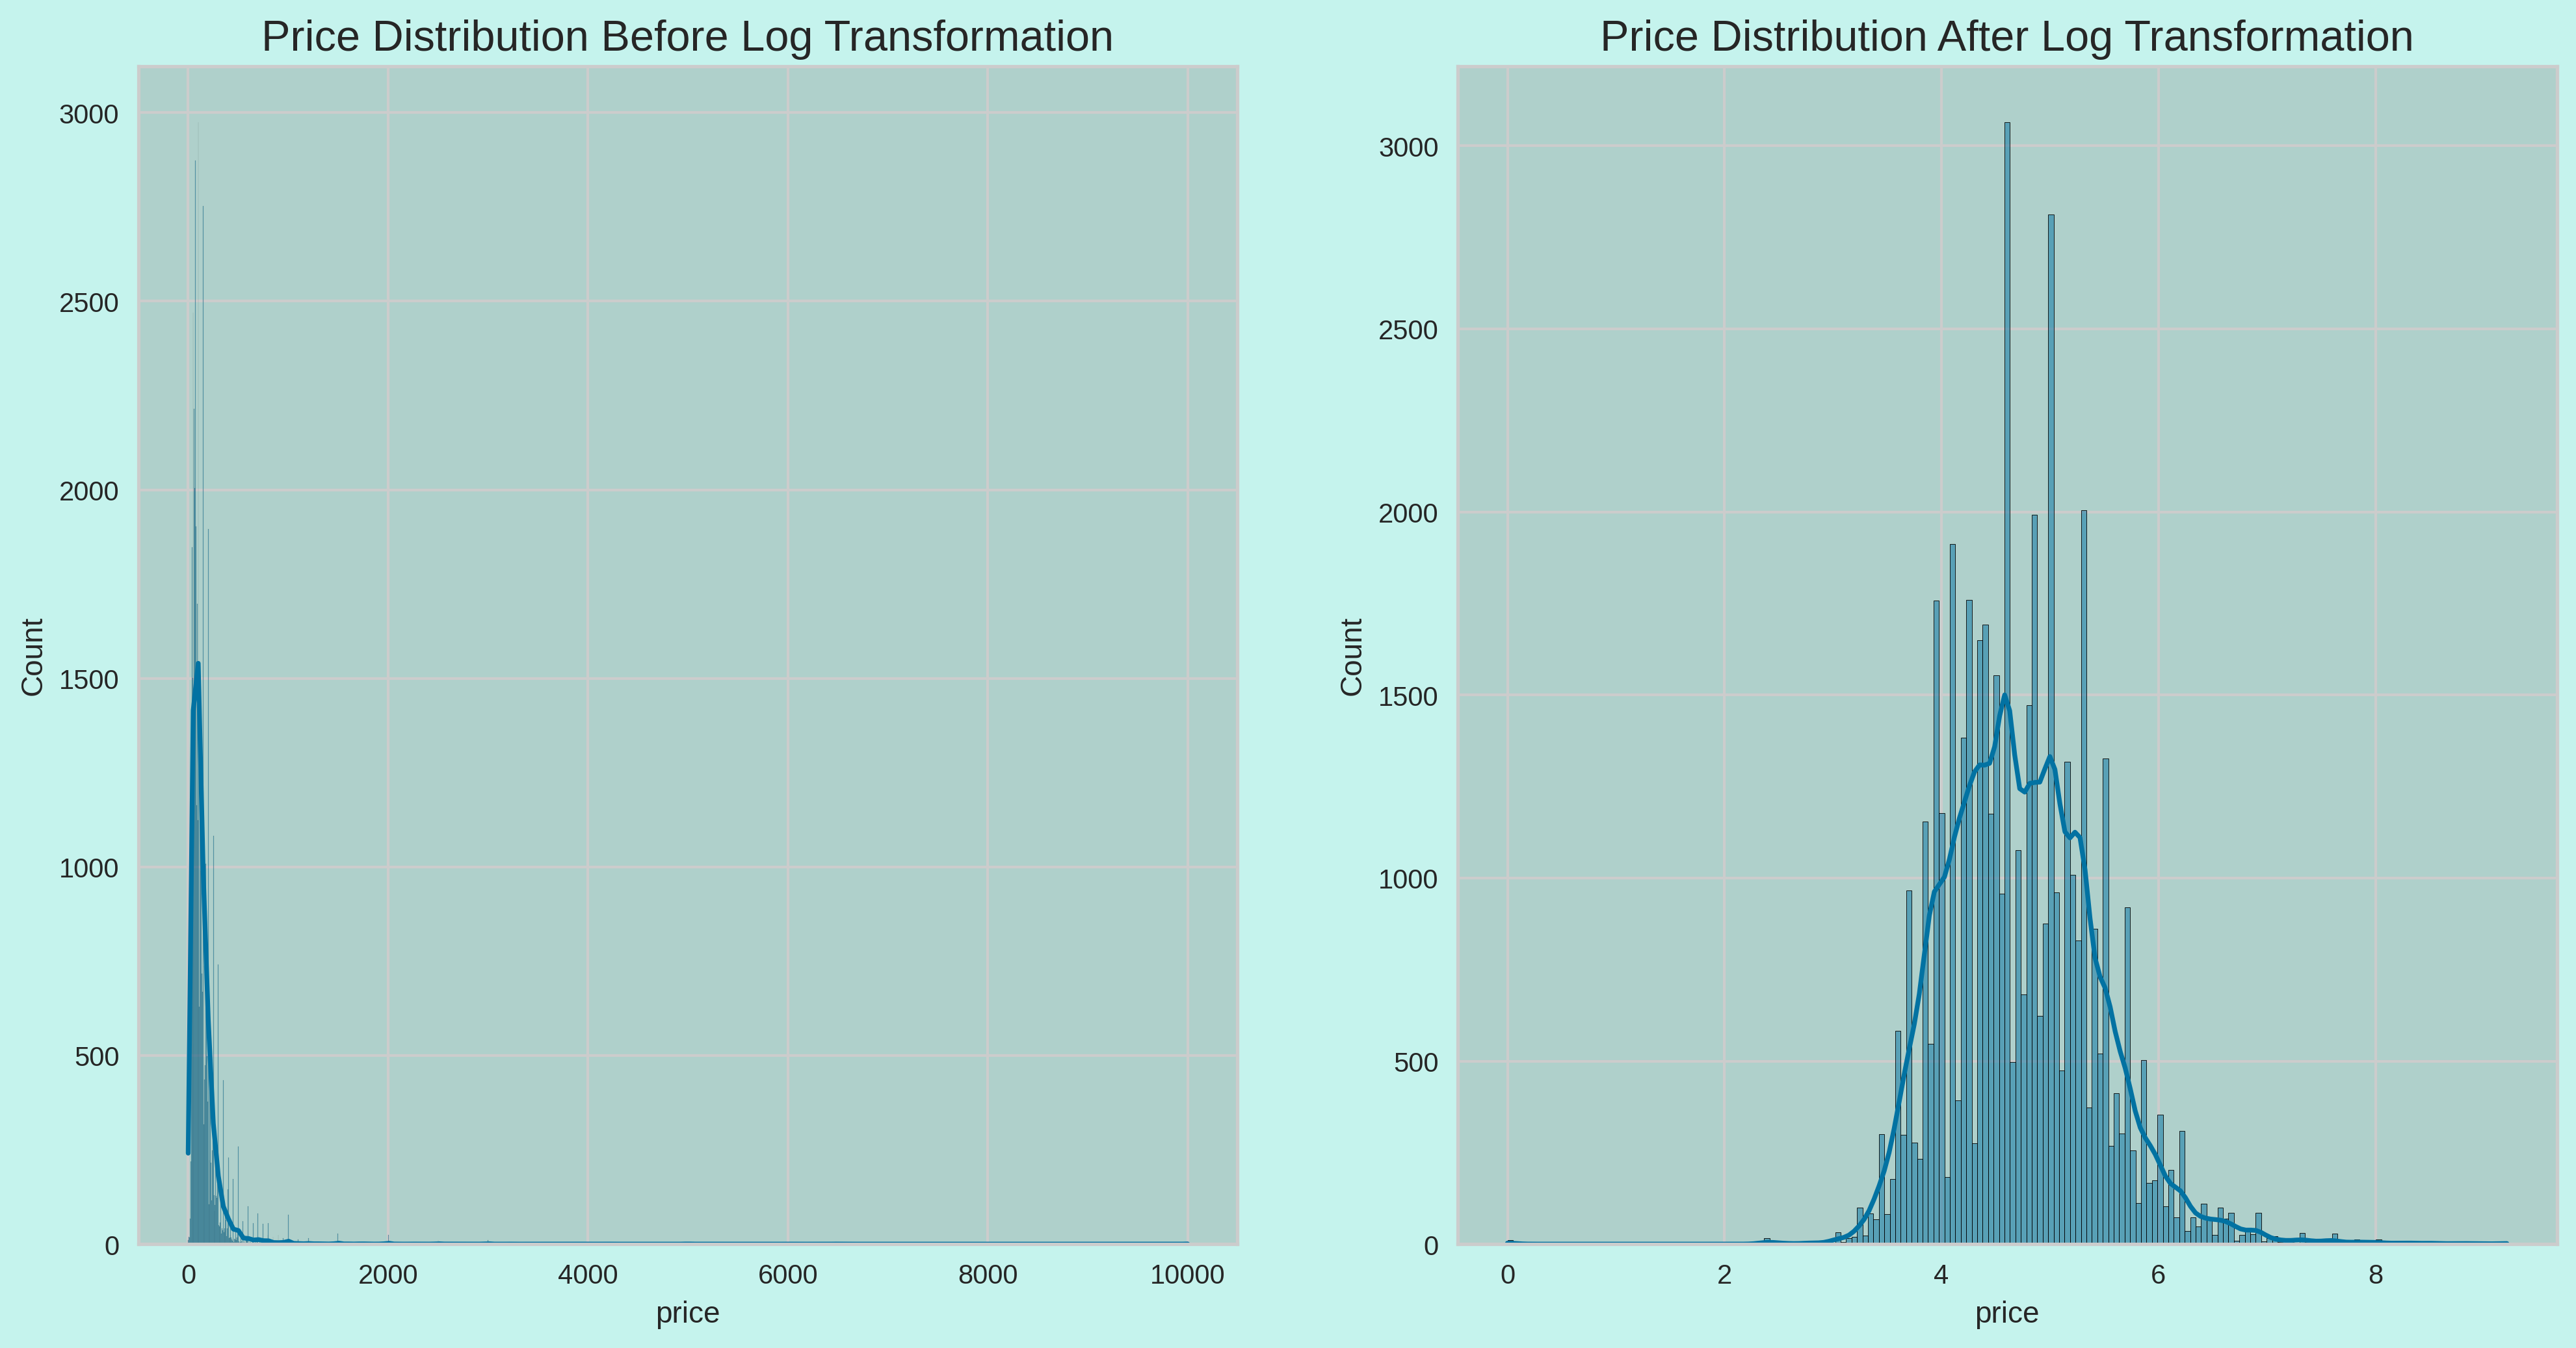

In [34]:
fig, ax = plt.subplots(1,2, figsize = (16,8), facecolor='#C5F3ED')
sns.histplot(data=data, x="price", kde=True, ax=ax[0]).set_title("Price Distribution Before Log Transformation",
                                                                size = 16)
sns.histplot(np.log1p(data.price), kde=True, ax=ax[1]).set_title("Price Distribution After Log Transformation",
                                                                size = 16)

The graph on the left shows that there is a right skewed distribution. To make a better statistical analysis and to get better scores, we will be applied log transformation for the price column

#Detection of Outliers

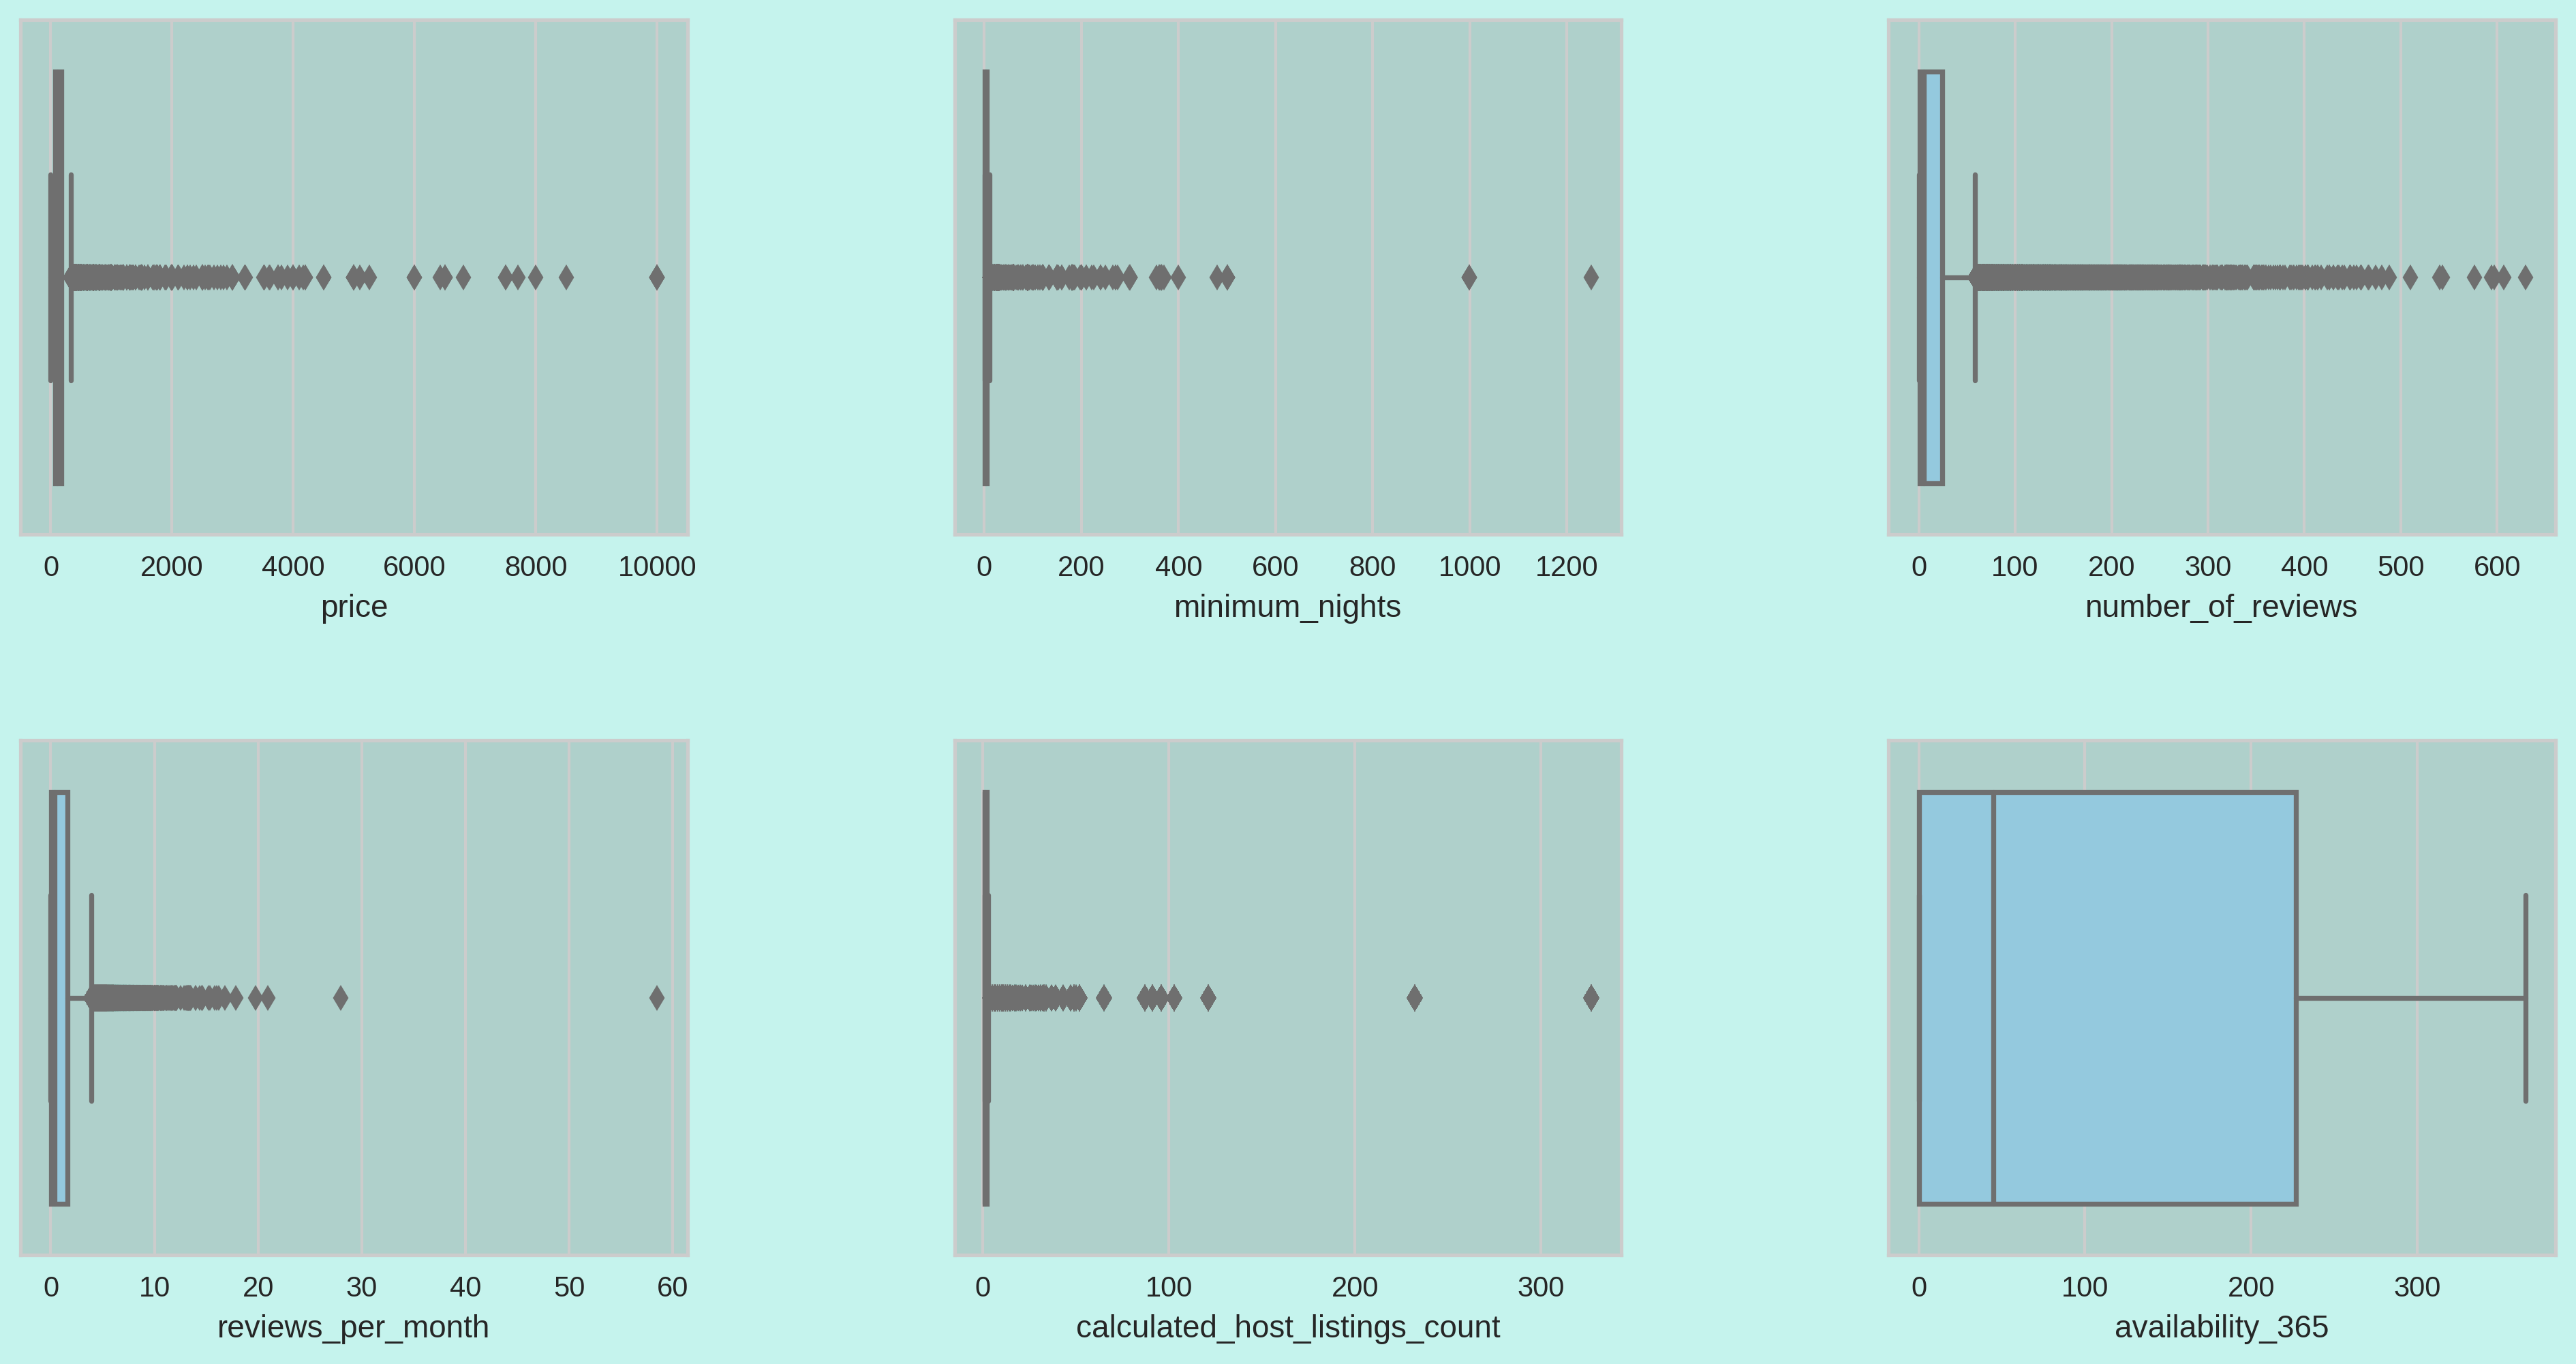

In [36]:
columns = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count",
          "availability_365"]
fig = plt.figure(facecolor='#C5F3ED', figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for num, column_name in enumerate(columns):
    ax = fig.add_subplot(2, 3, num +1)
    ax = sns.boxplot(x=data[column_name], color='skyblue')

In [38]:
q1_price = data["price"].quantile(0.25)
q3_price = data["price"].quantile(0.75)
iqr_price = q3_price - q1_price
lower_limit_price = q1_price - 1.5 * iqr_price
upper_limit_price = q3_price + 1.5 * iqr_price

df_filter_price = data[(data["price"] > lower_limit_price) & (data["price"] < upper_limit_price)]

df = df_filter_price

#Correlation matrix

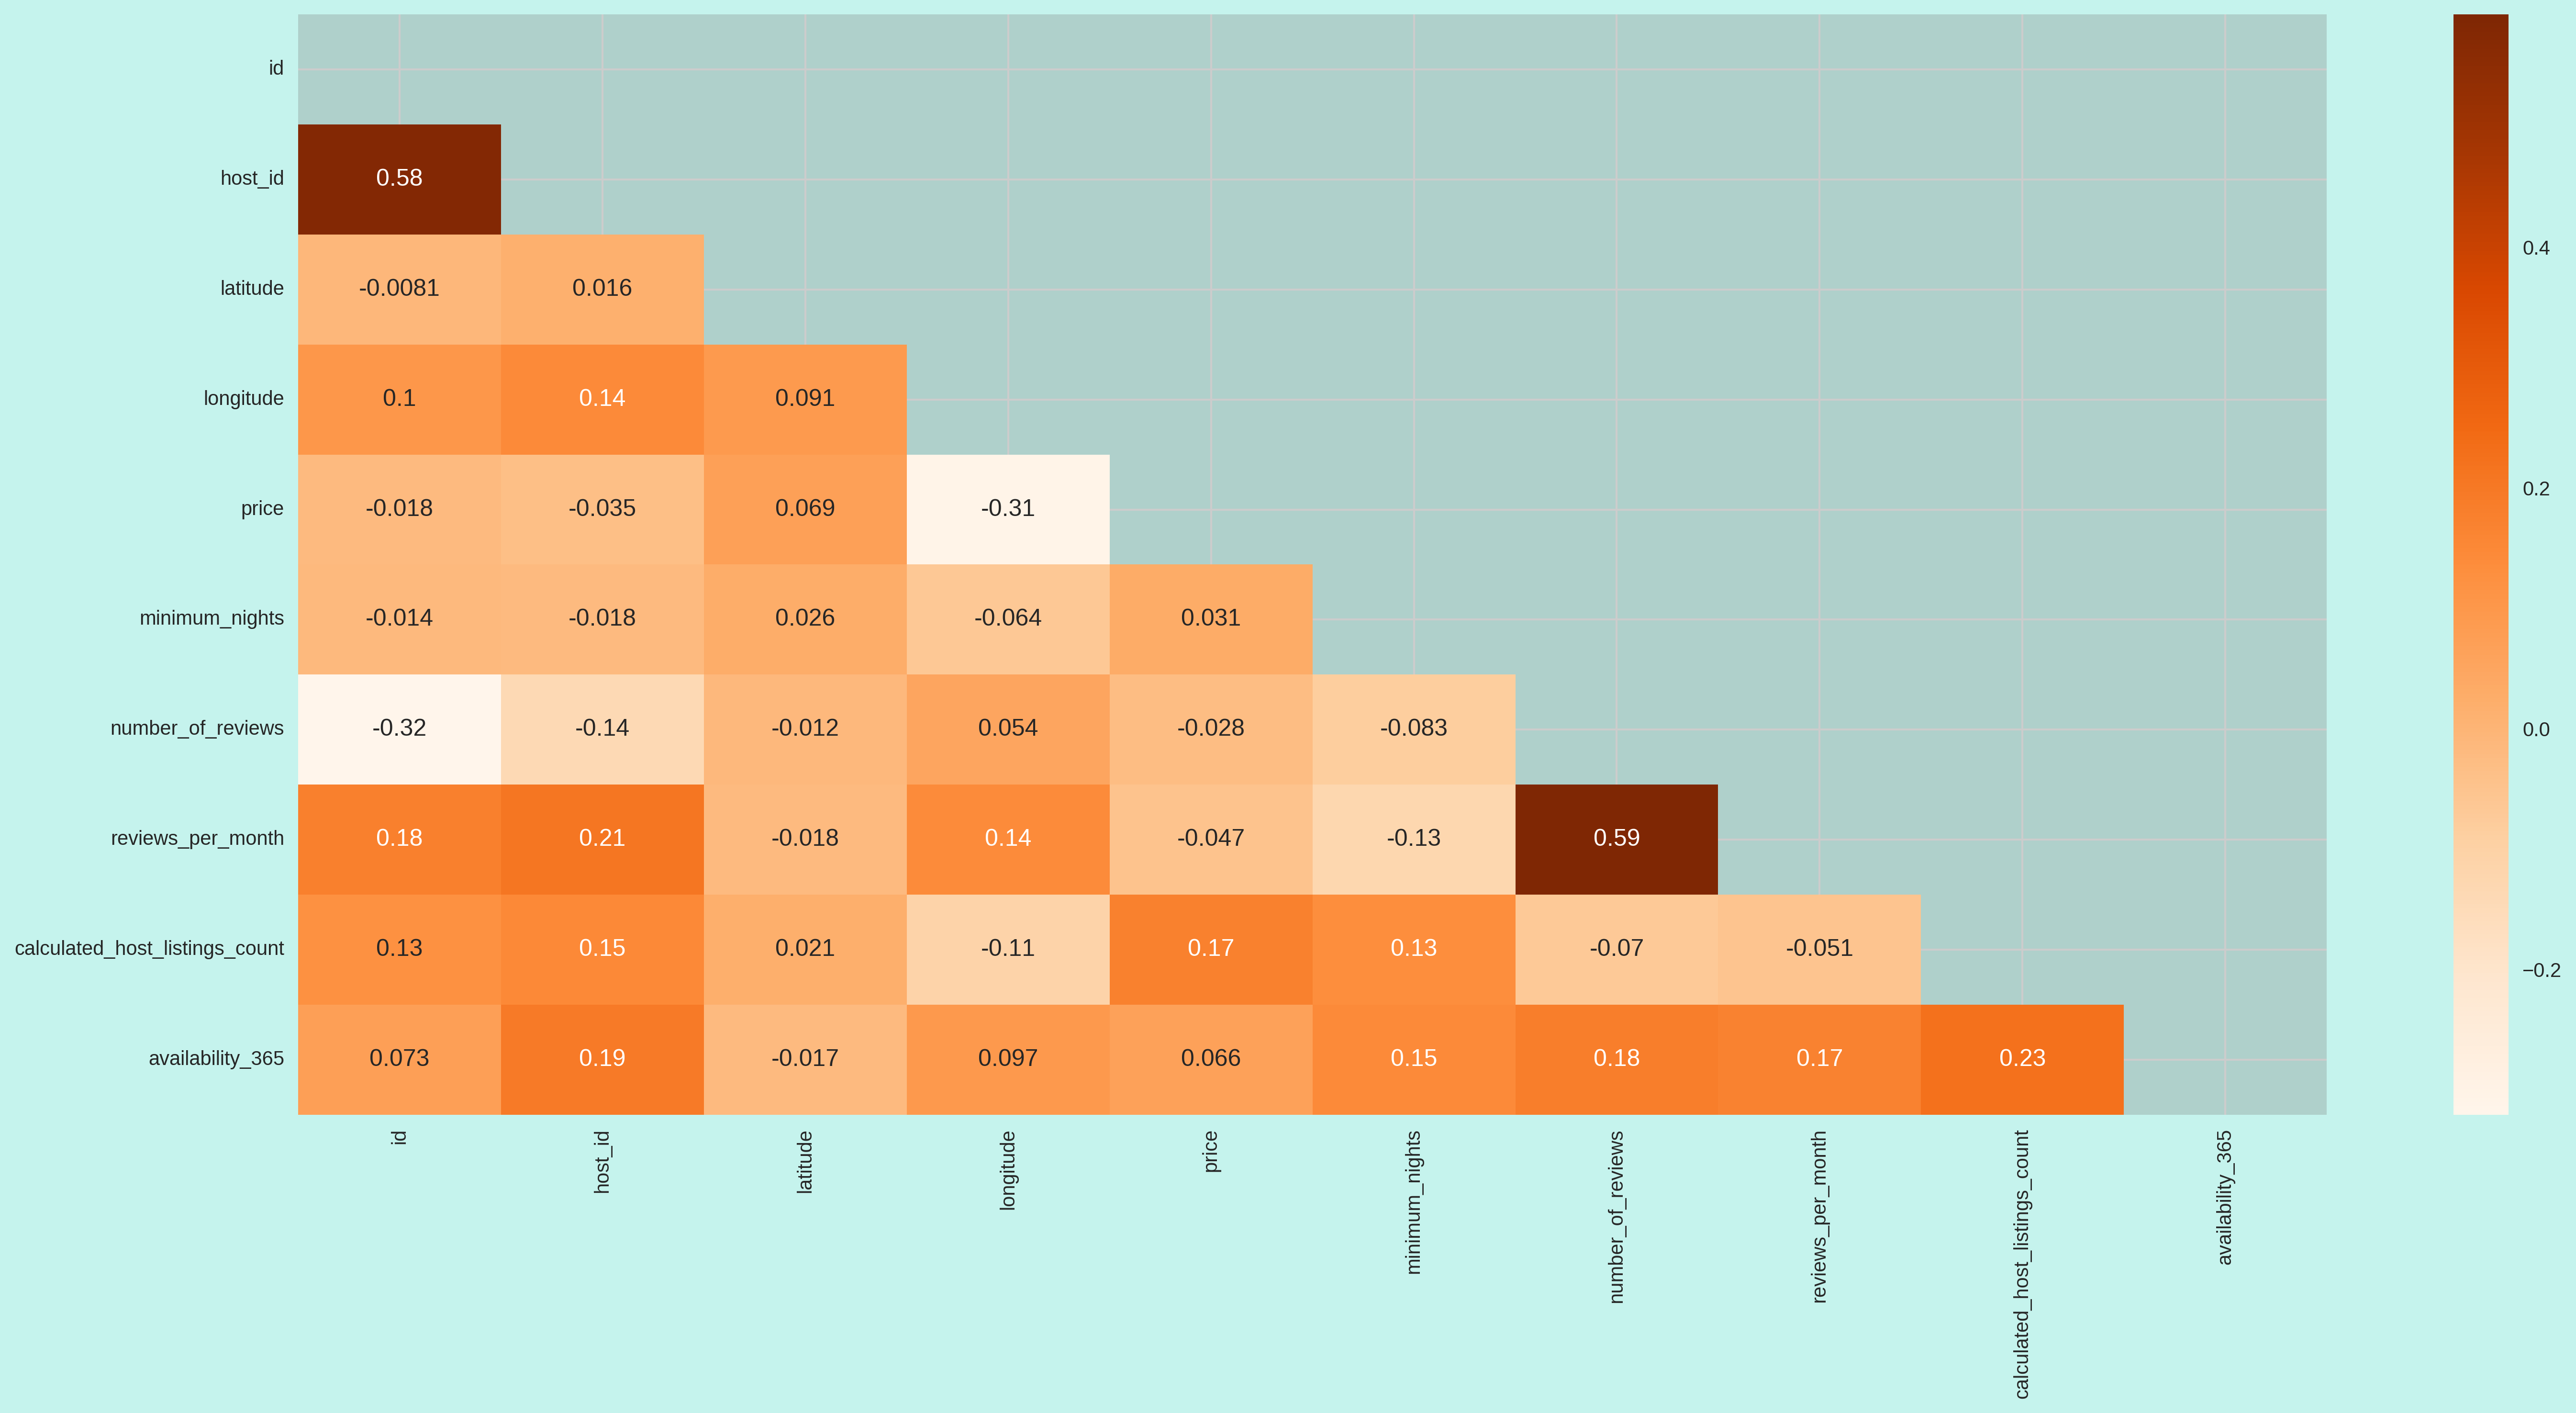

In [39]:
plt.figure(figsize=(20,10),facecolor='#C5F3ED')
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, cmap="Oranges")
plt.tight_layout()

##Data Preparation

Let's drop the columns that will not affect the price prediction.

In [46]:
data.drop(["id", "name", "host_id", "host_name"], axis = 1, inplace = True)

Applying log transformation for the price column.

In [47]:
data["price"] = np.log1p(data["price"])
X = data.drop("price", axis = 1)
y = data["price"]

### Splitting data into training and testing sets

> Prior to implementating or applying any Machine Learning algorithms, we must decouple training and testing datasets from our master dataframe.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [56]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
columns = ["neighbourhood_group", "neighbourhood", "room_type"]
ohe_df_train = pd.DataFrame(ohe.fit_transform(X_train[columns]).toarray(), columns=ohe.get_feature_names_out())
X_train_ohe = X_train.join(ohe_df_train).drop(columns, axis=1)

ohe_df_test = pd.DataFrame(ohe.transform(X_test[columns]).toarray(), columns=ohe.get_feature_names_out())
X_test_ohe = X_test.join(ohe_df_test).drop(columns, axis=1)

##Feature Scaling

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_ohe)
X_test = scaler.transform(X_test_ohe)

#Model Building and Comparison

Lasso Regression, Ridge Regression, Decision Tree Regressor and Random Forest Regressor models will be built in the model building section.

In [102]:
def models(X_train, X_test, y_train, y_test):
    
    models = pd.DataFrame(columns=["Model","Test Sc.","Train Sc.","MAE","MSE","RMSE", "RMSE CV"])
    '''
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = lr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    lr_row = {"Model": "Linear Regression", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(lr_row, ignore_index=True)

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = ridge.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
   
    rmse_cv = np.sqrt(-cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    ridge_row = {"Model": "Ridge", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(ridge_row, ignore_index=True)
    
    
    
    lasso = Lasso(alpha = 0.0001)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
   
    test_score = r2_score(y_test, y_pred)
    train_score = lasso.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
   
    rmse_cv = np.sqrt(-cross_val_score(lasso, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    lasso_row = {"Model": "Lasso", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(lasso_row, ignore_index=True)
    
    
    dtr = DecisionTreeRegressor(min_samples_leaf=60)
    dtr.fit(X_train, y_train)
    y_pred= dtr.predict(X_test)
   
    test_score = r2_score(y_test, y_pred)
    train_score = dtr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmse_cv = np.sqrt(-cross_val_score(dtr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    dtr_row = {"Model": "DTR", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(dtr_row, ignore_index=True)
    
    
    rfr = RandomForestRegressor(random_state = 42,
                                n_estimators = 120,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = 27,
                                bootstrap = True)
    rfr.fit(X_train, y_train)
    y_pred= rfr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = rfr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(rfr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    
    rfr_row = {"Model": "RFR", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(rfr_row, ignore_index=True)

    etr = ExtraTreesRegressor()
    etr.fit(X_train,y_train)

    y_pred= etr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = etr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(etr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    
    etr_row = {"Model": "ExtraTree Random Forest", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(etr_row, ignore_index=True)

    gbr = GradientBoostingRegressor()
    gbr.fit(X_train,y_train)

    y_pred= gbr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = gbr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(gbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    gbr_row = {"Model": "Gradient Boosting", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}

    
    models = models.append(gbr_row, ignore_index=True)
    '''
    xgbr = xgb.XGBRegressor()
    xgbr.fit(X_train,y_train)

    y_pred= xgbr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = xgbr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(xgbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    xgbr_row = {"Model": "XGBoost", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}

    
    models = models.append(xgbr_row, ignore_index=True)

    cbr = cb.CatBoostRegressor(loss_function='RMSE')
    cbr.fit(X_train,y_train)

    y_pred= cbr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = cbr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(cbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    cbr_row = {"Model": "CAT Boost", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}

    
    models = models.append(cbr_row, ignore_index=True)


    display(models.style.highlight_min(subset=["MAE","MSE","RMSE", "RMSE CV"], 
                                                color = 'springgreen', axis = 0).highlight_max(
        subset=["Test Sc.", "Train Sc."], color = 'springgreen', axis = 0))
    
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,6), dpi=300)
    plt.subplots_adjust(hspace=1.2)
    sns.lineplot(x=models["Model"], y=models["Test Sc."], ax=ax1, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["Train Sc."], ax=ax2, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["MAE"], ax=ax3, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["MSE"], ax=ax4, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["RMSE"], ax=ax5, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["RMSE CV"], ax=ax6, marker="o", color="yellow")
    ax1.set_title("Test Scores Comparison", size=18)
    ax2.set_title("Train Scores Comparison", size=18)
    ax3.set_title("MAE Scores Comparison", size=18)
    ax4.set_title("MSE Scores Comparison", size=18)
    ax5.set_title("RMSE Scores Comparison", size=18)
    ax6.set_title("RMSE CV Scores Comparison", size=18)
    ax1.tick_params(labelrotation=30)
    ax2.tick_params(labelrotation=30)
    ax3.tick_params(labelrotation=30)
    ax4.tick_params(labelrotation=30)
    ax5.tick_params(labelrotation=30)
    ax6.tick_params(labelrotation=30)
    plt.show()

In [ ]:
models(X_train, X_test, y_train, y_test)

Streaming output truncated to the last 5000 lines.
543:	learn: 0.4184828	total: 4.84s	remaining: 4.05s
544:	learn: 0.4184798	total: 4.84s	remaining: 4.04s
545:	learn: 0.4184416	total: 4.84s	remaining: 4.03s
546:	learn: 0.4184160	total: 4.85s	remaining: 4.02s
547:	learn: 0.4183885	total: 4.86s	remaining: 4.01s
548:	learn: 0.4183863	total: 4.87s	remaining: 4s
549:	learn: 0.4183784	total: 4.87s	remaining: 3.98s
550:	learn: 0.4183395	total: 4.88s	remaining: 3.97s
551:	learn: 0.4182344	total: 4.88s	remaining: 3.96s
552:	learn: 0.4181850	total: 4.89s	remaining: 3.95s
553:	learn: 0.4181787	total: 4.89s	remaining: 3.94s
554:	learn: 0.4181456	total: 4.9s	remaining: 3.93s
555:	learn: 0.4181434	total: 4.9s	remaining: 3.91s
556:	learn: 0.4181028	total: 4.91s	remaining: 3.9s
557:	learn: 0.4180607	total: 4.91s	remaining: 3.89s
558:	learn: 0.4180529	total: 4.92s	remaining: 3.88s
559:	learn: 0.4180170	total: 4.92s	remaining: 3.87s
560:	learn: 0.4180103	total: 4.93s	remaining: 3.85s
561:	learn: 0.41796

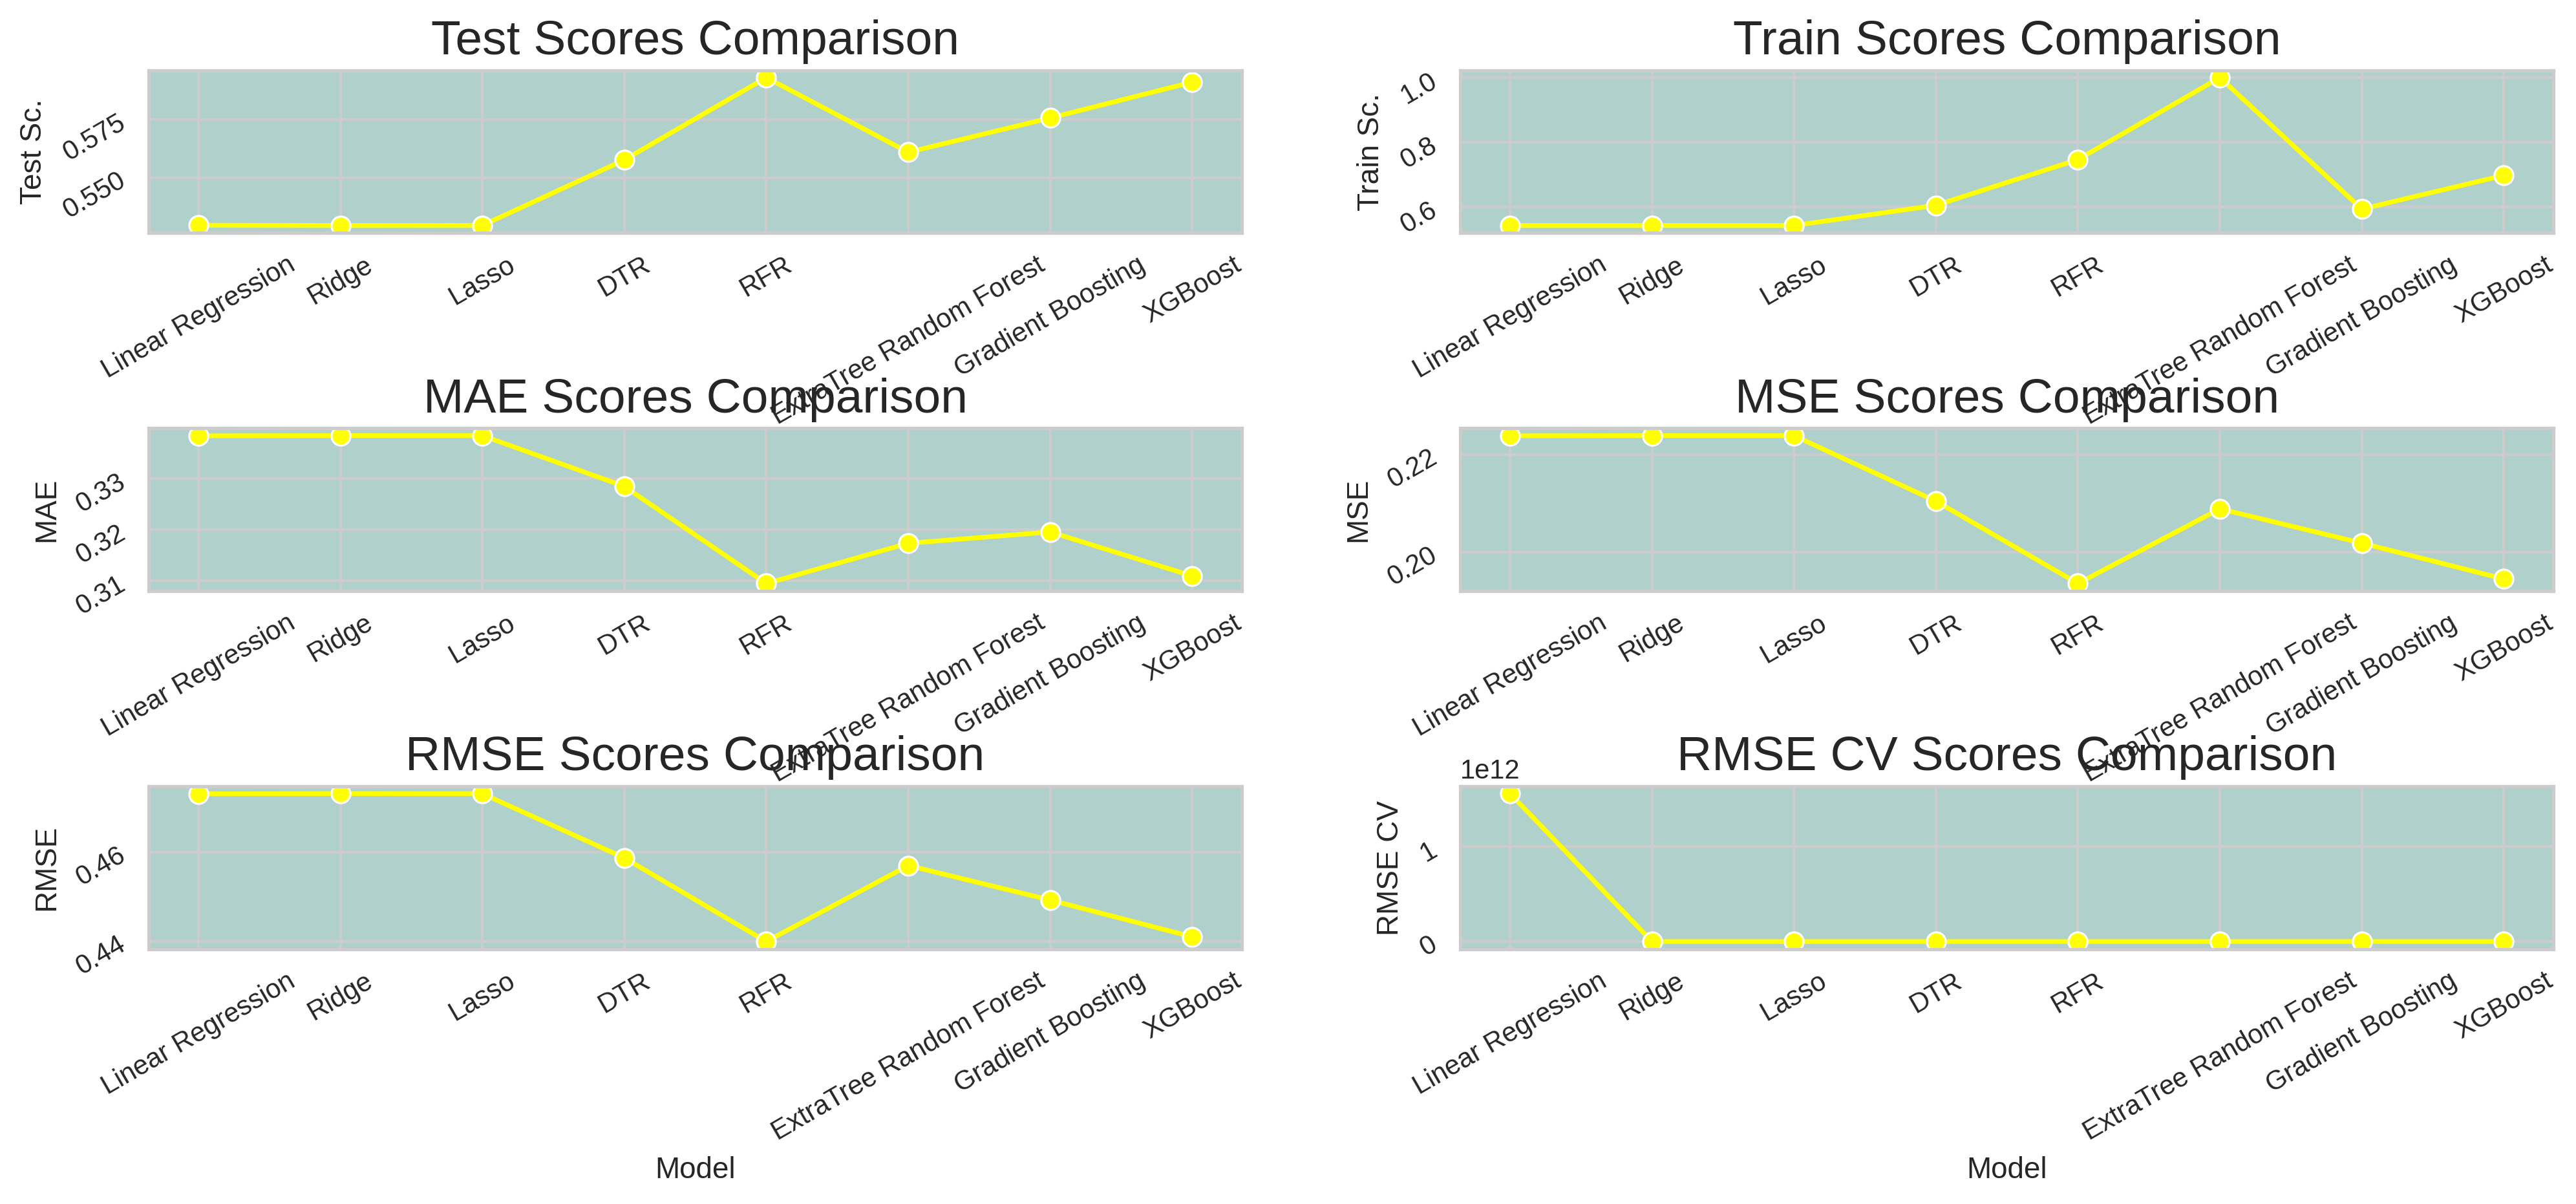

In [95]:
models(X_train, X_test, y_train, y_test)

In [73]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [76]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

NameError: ignored